# Colab Requirements

In [1]:
# # imports
# from google.colab import drive

# # read from google drive files
# drive.mount("/content/drive")

# # pip
# !pip install inflection
# !pip install boruta

# # path
# #df_sales_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train.csv', low_memory = False)
# #df_store_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/store.csv', low_memory = False)

# 0.0. IMPORTS

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns

import math
import inflection
import datetime
import pickle
import matplotlib.pyplot as plt

from scipy                import stats as ss
from random               import sample
from boruta               import BorutaPy
from IPython.core.display import HTML
from IPython.display      import Image


import xgboost as xgb
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed(range(1, kfold+1)):
    if verbose:
      print('\nKFold Number: {}'.format(k))

    # datas de início e fim da validação
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtrando o dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

    # dataset de treino e validação
    # treino
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    # validação
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # modelo
    m = model.fit(xtraining, ytraining)

    # predição
    yhat = m.predict(xvalidation)

    # performance
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
    # listar performance de cada iteração
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str), 
                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str), 
                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])


def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k-1 )*( r-1 )/( n-1 ))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/renato/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6. Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [14]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_3038/1604121253.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['customers'])


<AxesSubplot: xlabel='customers', ylabel='Density'>

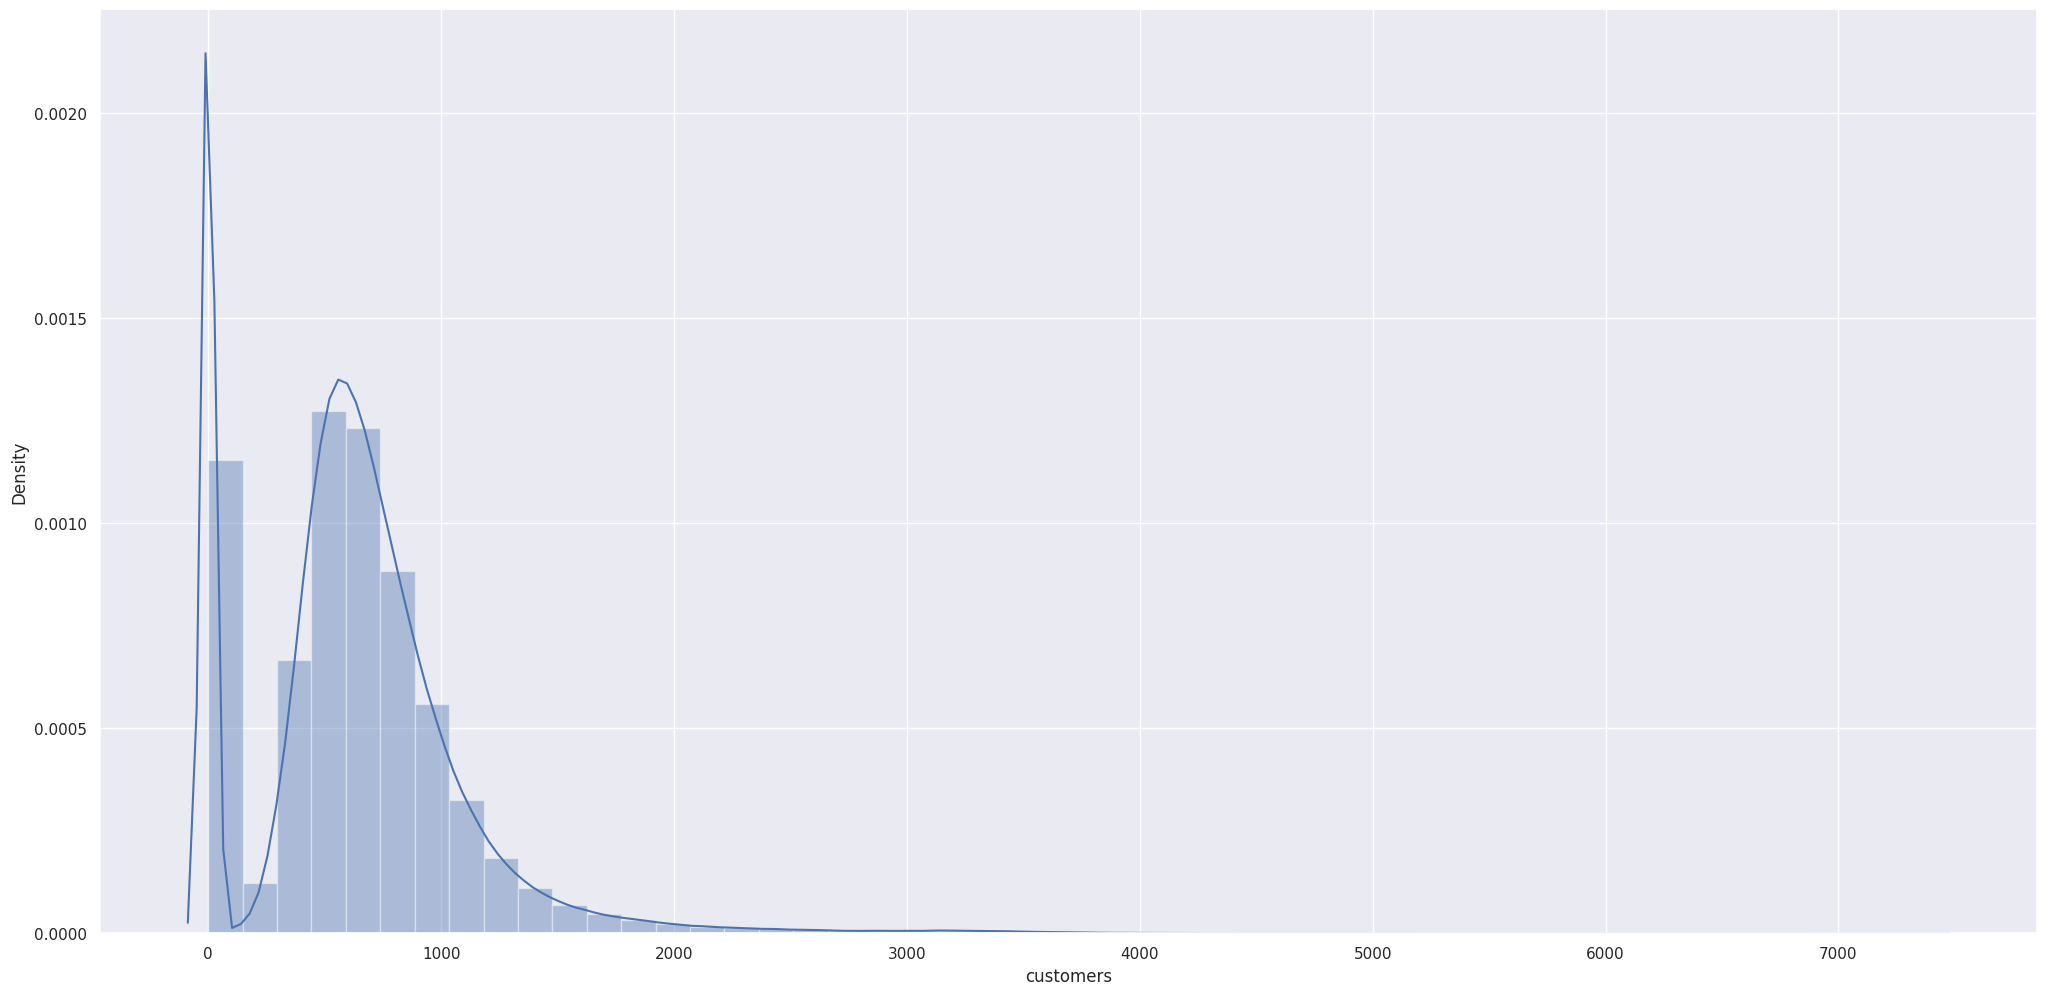

In [15]:
sns.distplot(df1['customers'])

### 1.7.2. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

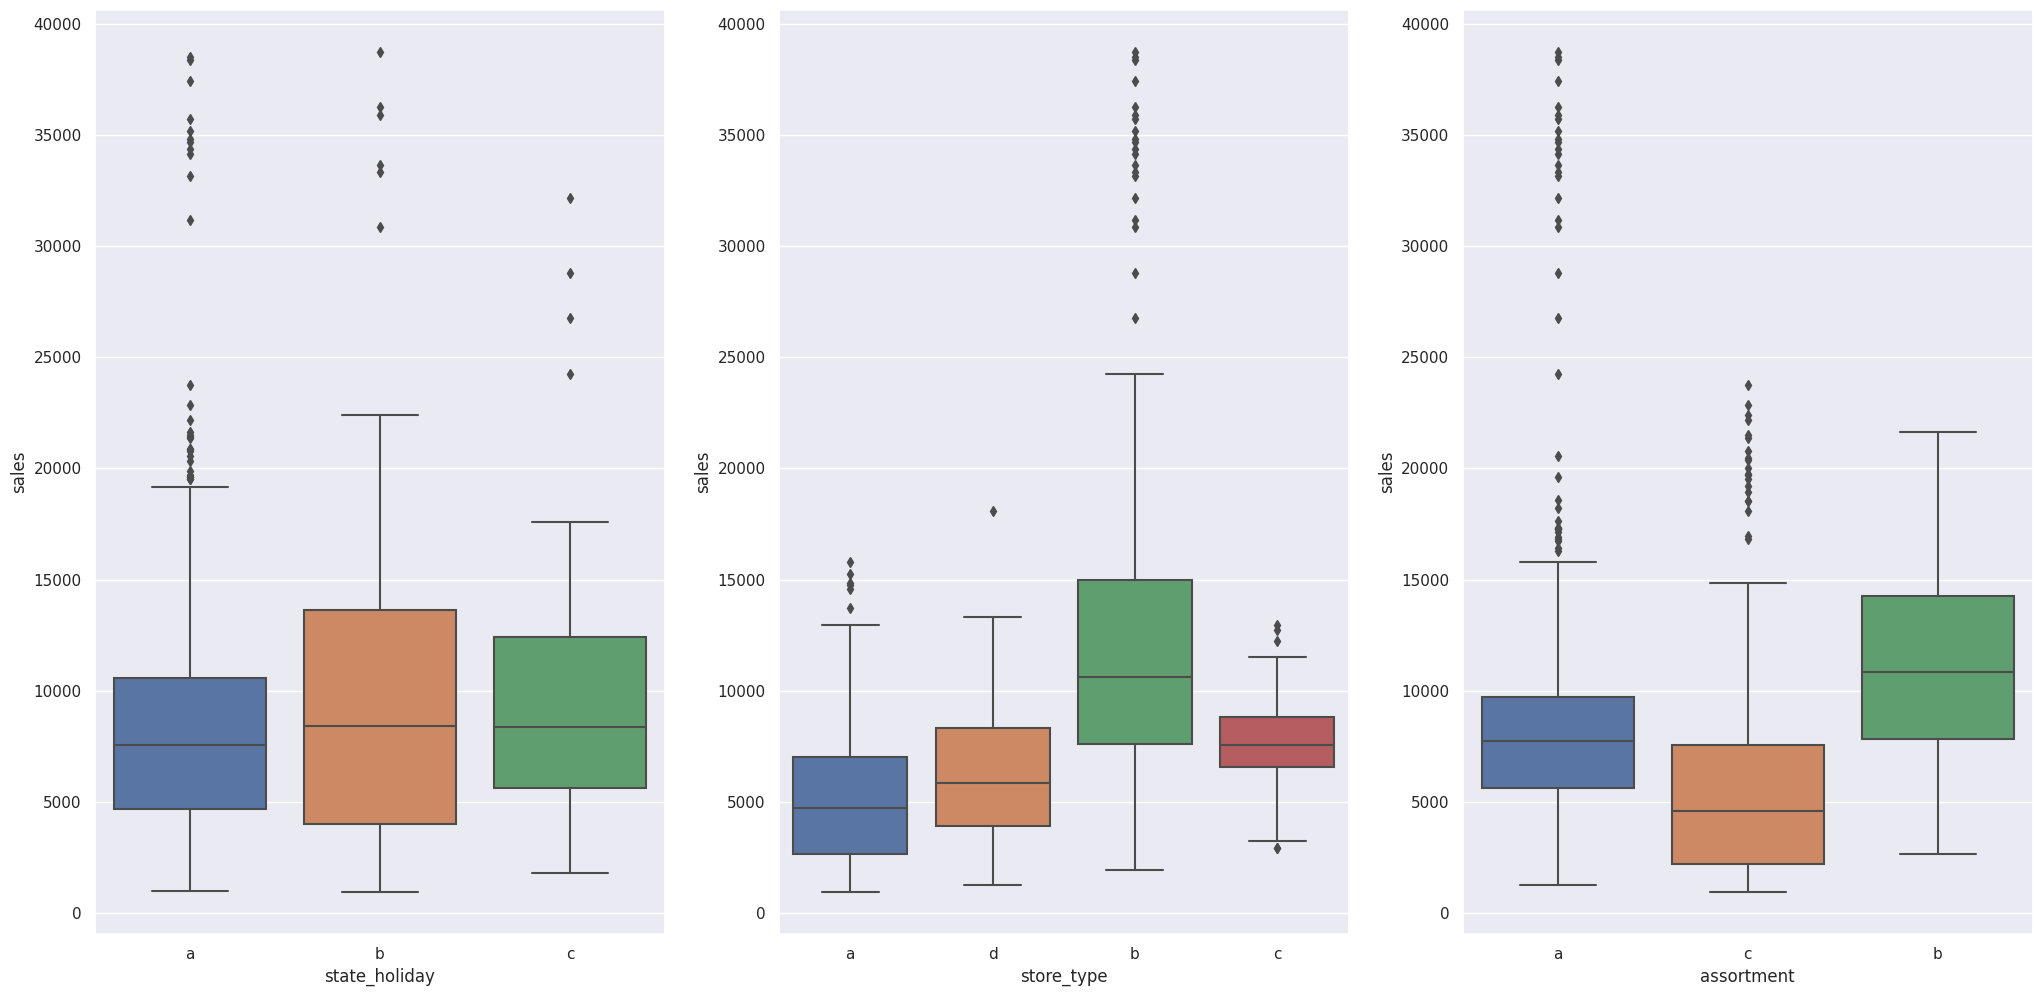

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(data = aux1, x = 'state_holiday', y = 'sales');

plt.subplot(1, 3, 2)
sns.boxplot(data = aux1, x = 'store_type', y = 'sales');

plt.subplot(1, 3, 3)
sns.boxplot(data = aux1, x = 'assortment', y = 'sales');

# 2.0. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

In [19]:
#Image('img/MindMapHypotheses.png')

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam verder mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição dos produtos deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

**7.** Lojas que tem mais feriados deveriam vender menos.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

**13.** Lojas que tem mais feriados deveriam vender menos.

## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIÁVEIS

In [21]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [24]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

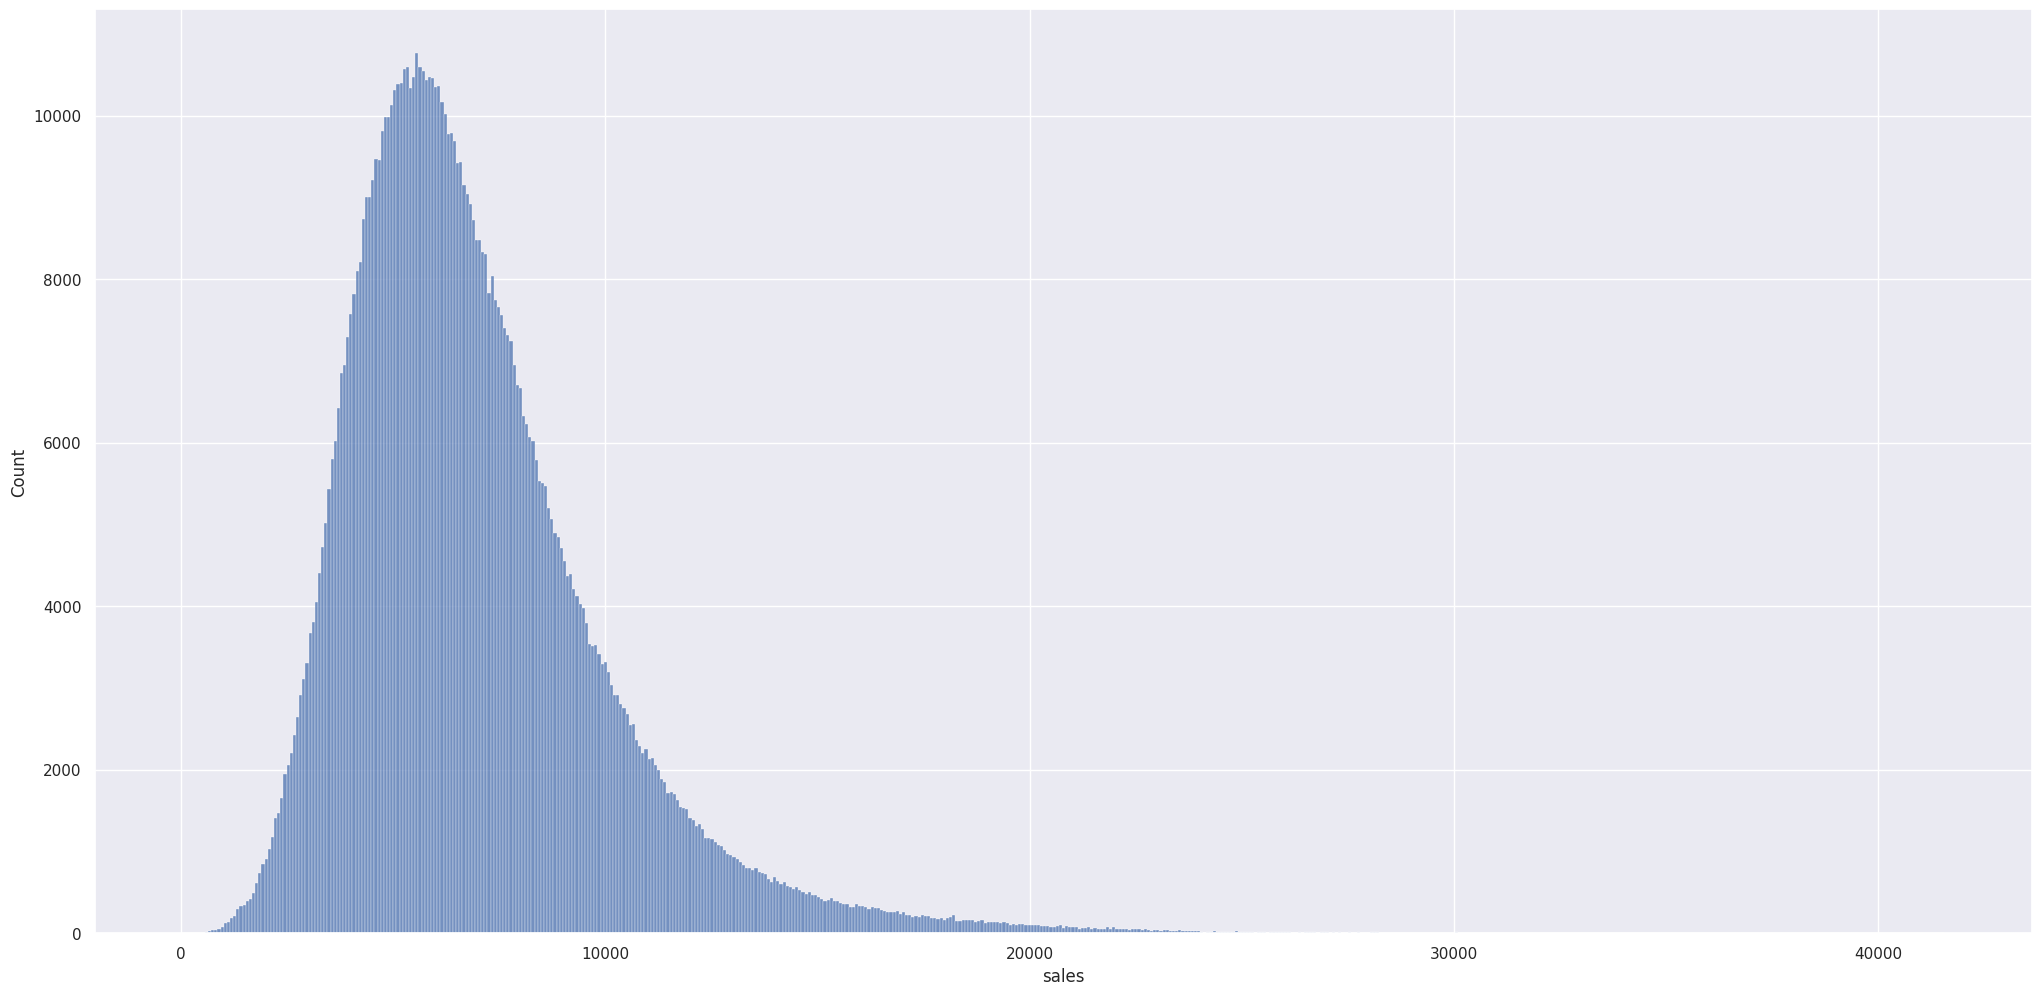

In [25]:
sns.histplot(df4['sales']);

### 4.1.2. Variáveis Numéricas

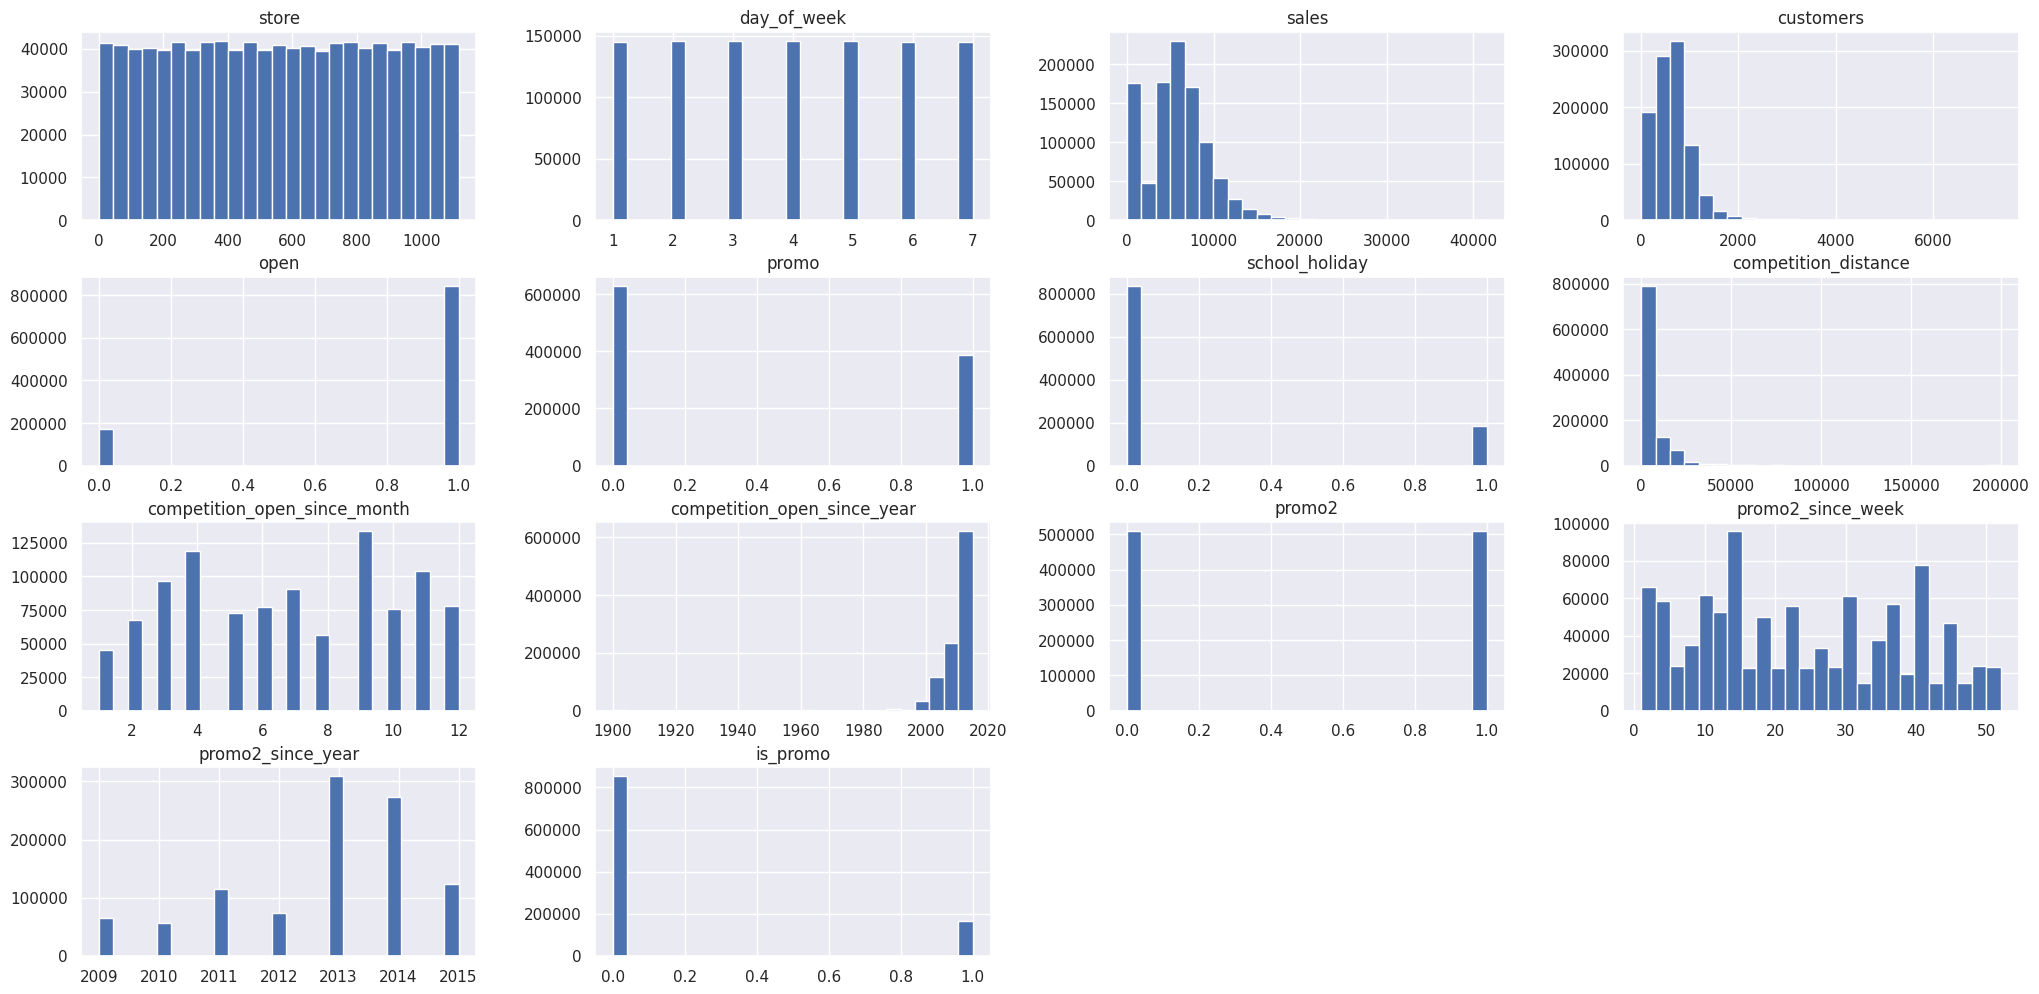

In [26]:
num_attributes.hist(bins=25);

### 4.1.3. Variáveis Categóricas

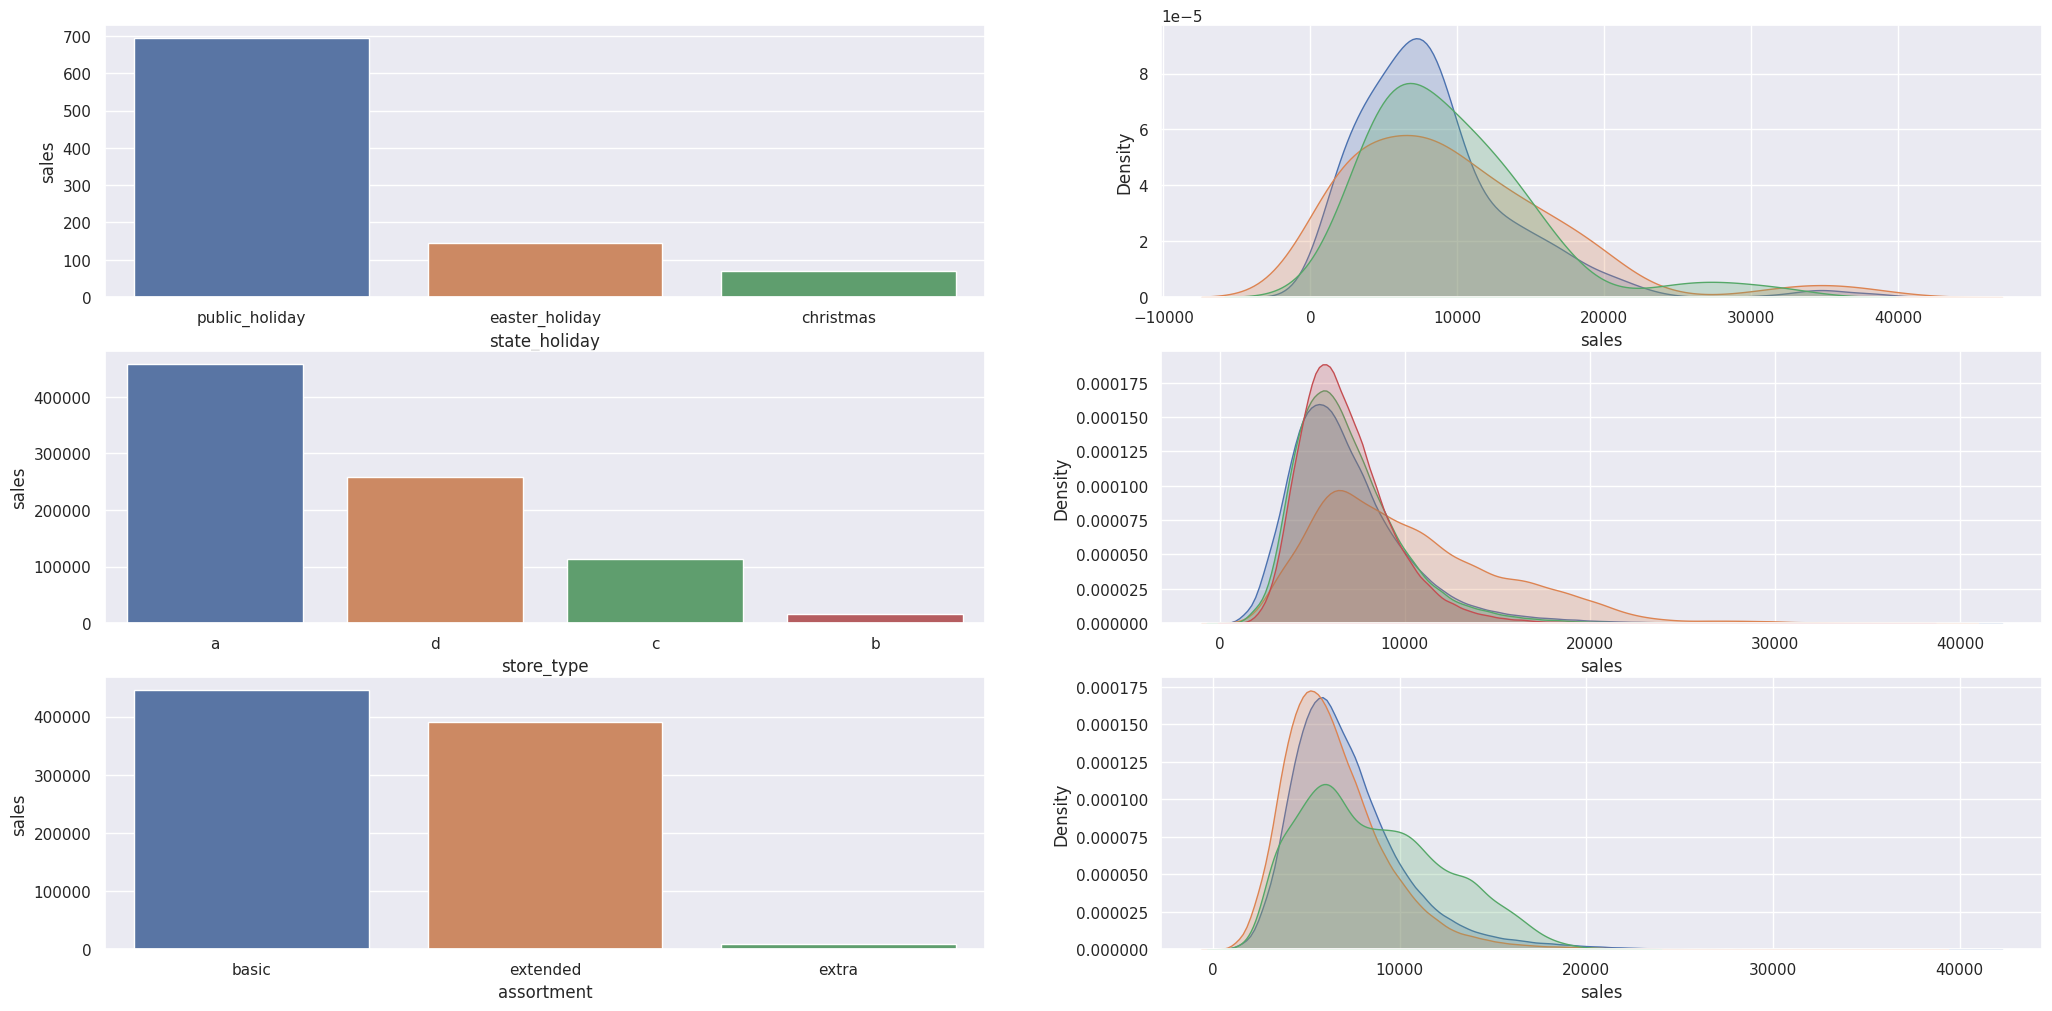

In [27]:
# state_holiday
plt.subplot(3, 2, 1)
grouped = df4.loc[ (df4['state_holiday'] != 'regular_day'), ['state_holiday', 'sales'] ].groupby( 'state_holiday' ).count().reset_index().sort_values('sales', ascending = False)
sns.barplot(data = grouped, x = 'state_holiday', y = 'sales');

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True);

# store_type
plt.subplot(3, 2, 3)
grouped = df4.loc[ : , ['store_type', 'sales'] ].groupby( 'store_type' ).count().reset_index().sort_values('sales', ascending = False)
sns.barplot(data = grouped, x = 'store_type', y = 'sales');

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True);

# assortment
plt.subplot(3, 2, 5)
grouped = df4.loc[ : , ['assortment', 'sales'] ].groupby( 'assortment' ).count().reset_index().sort_values('sales', ascending = False)
sns.barplot(data = grouped, x = 'assortment', y = 'sales');

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True);


## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

<AxesSubplot: xlabel='year_week'>

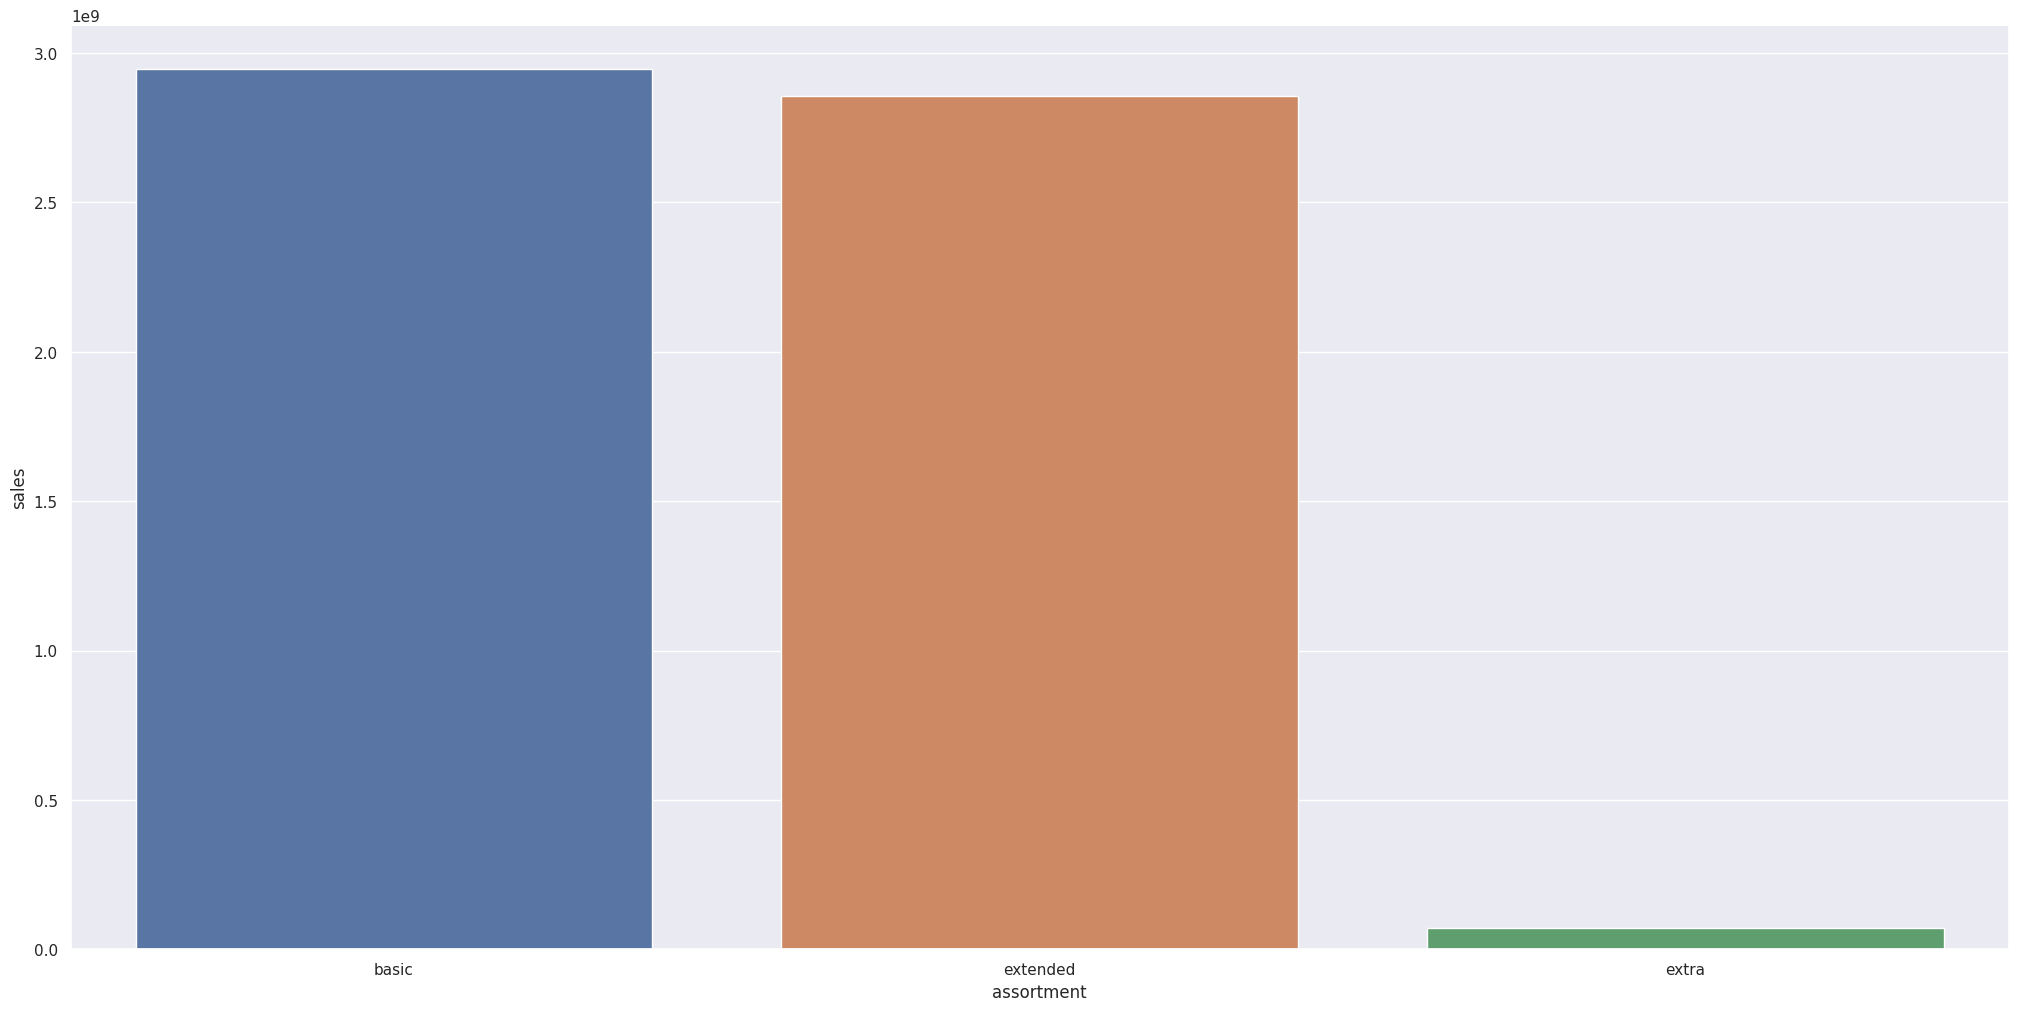

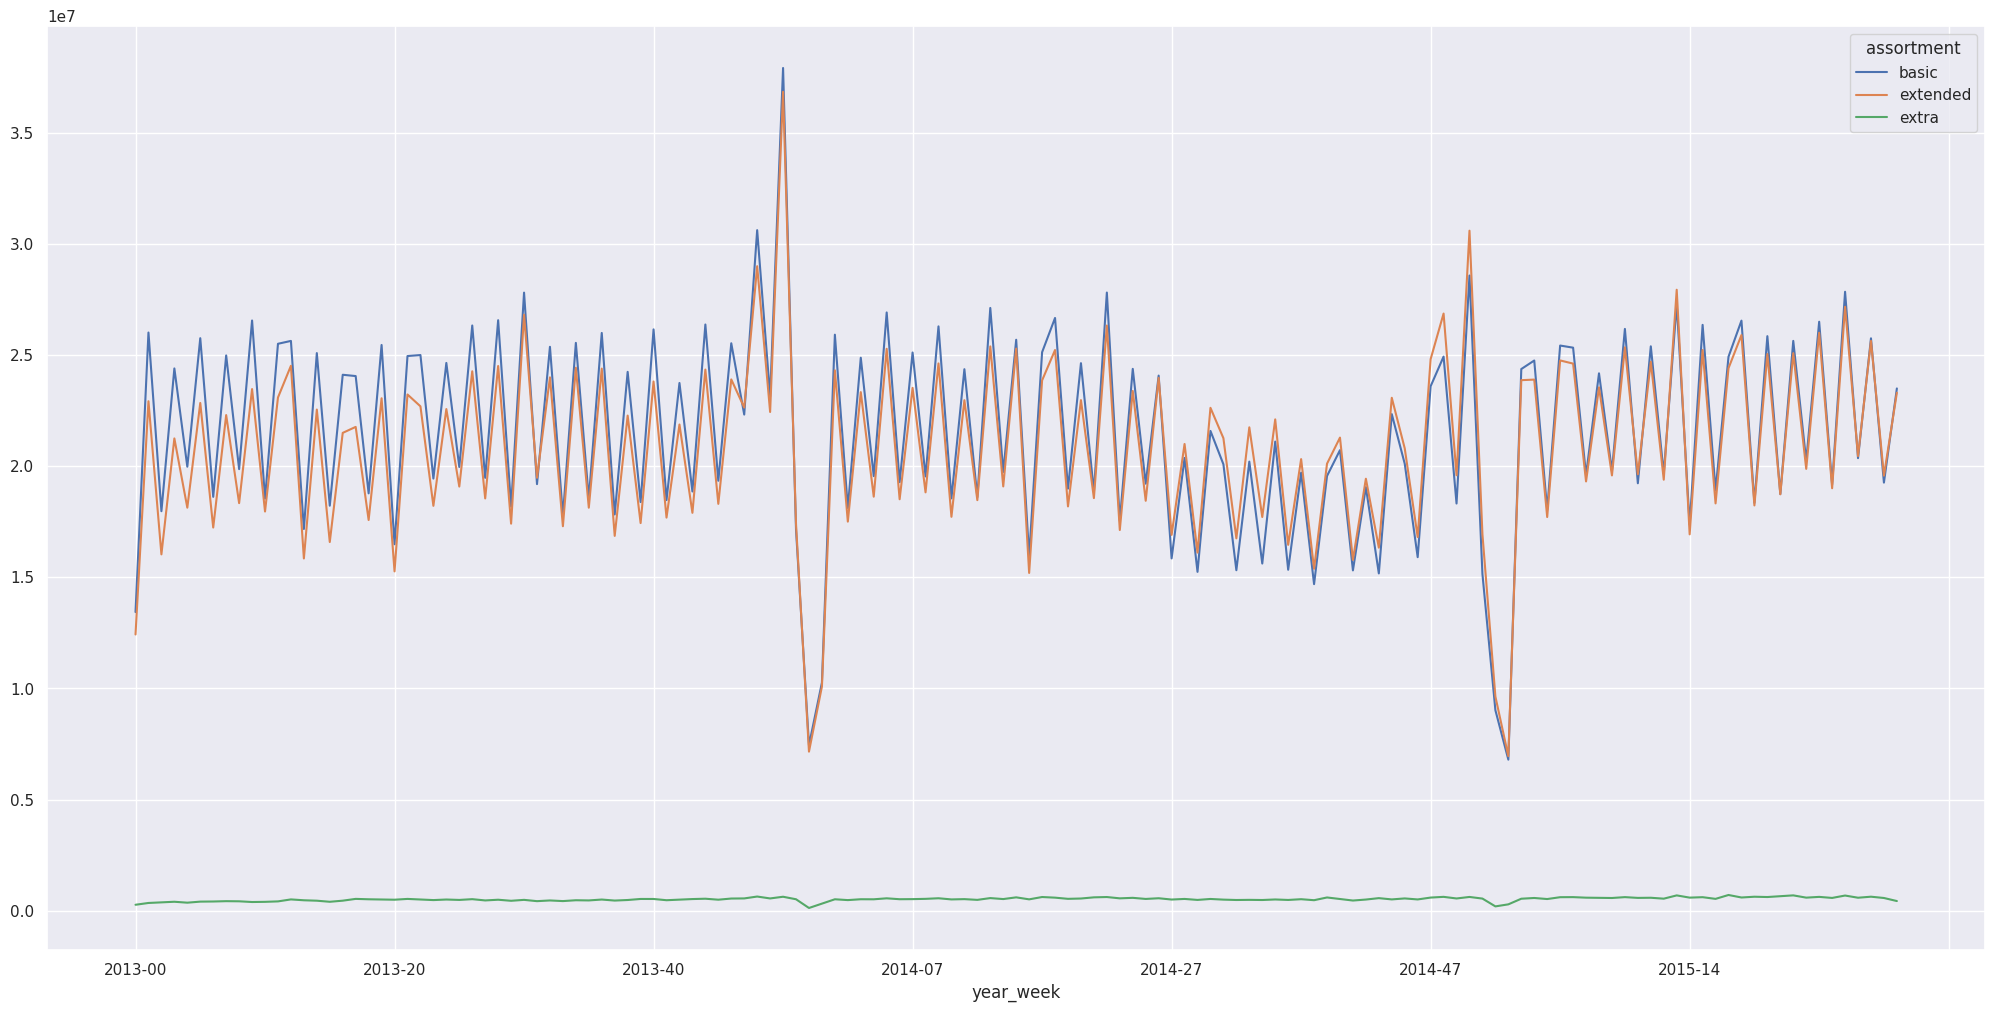

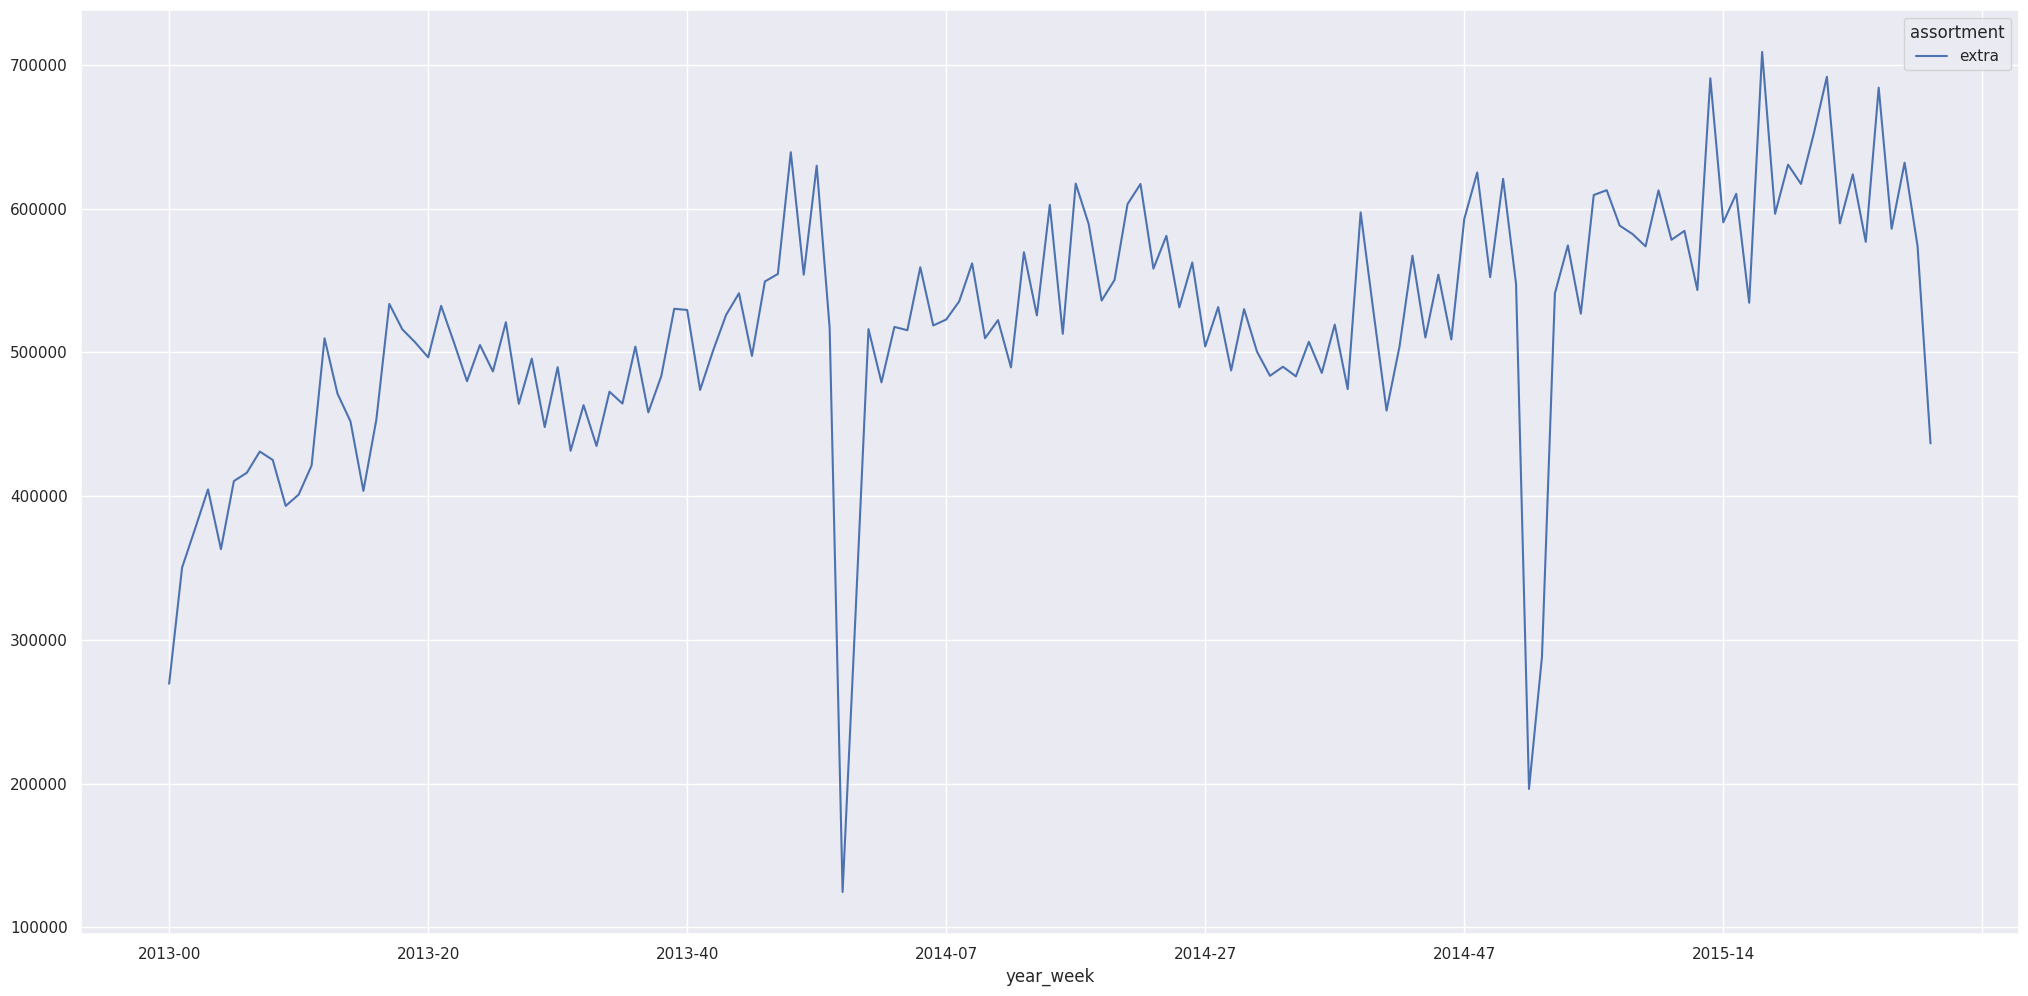

In [28]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais.

/tmp/ipykernel_3038/3267995595.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


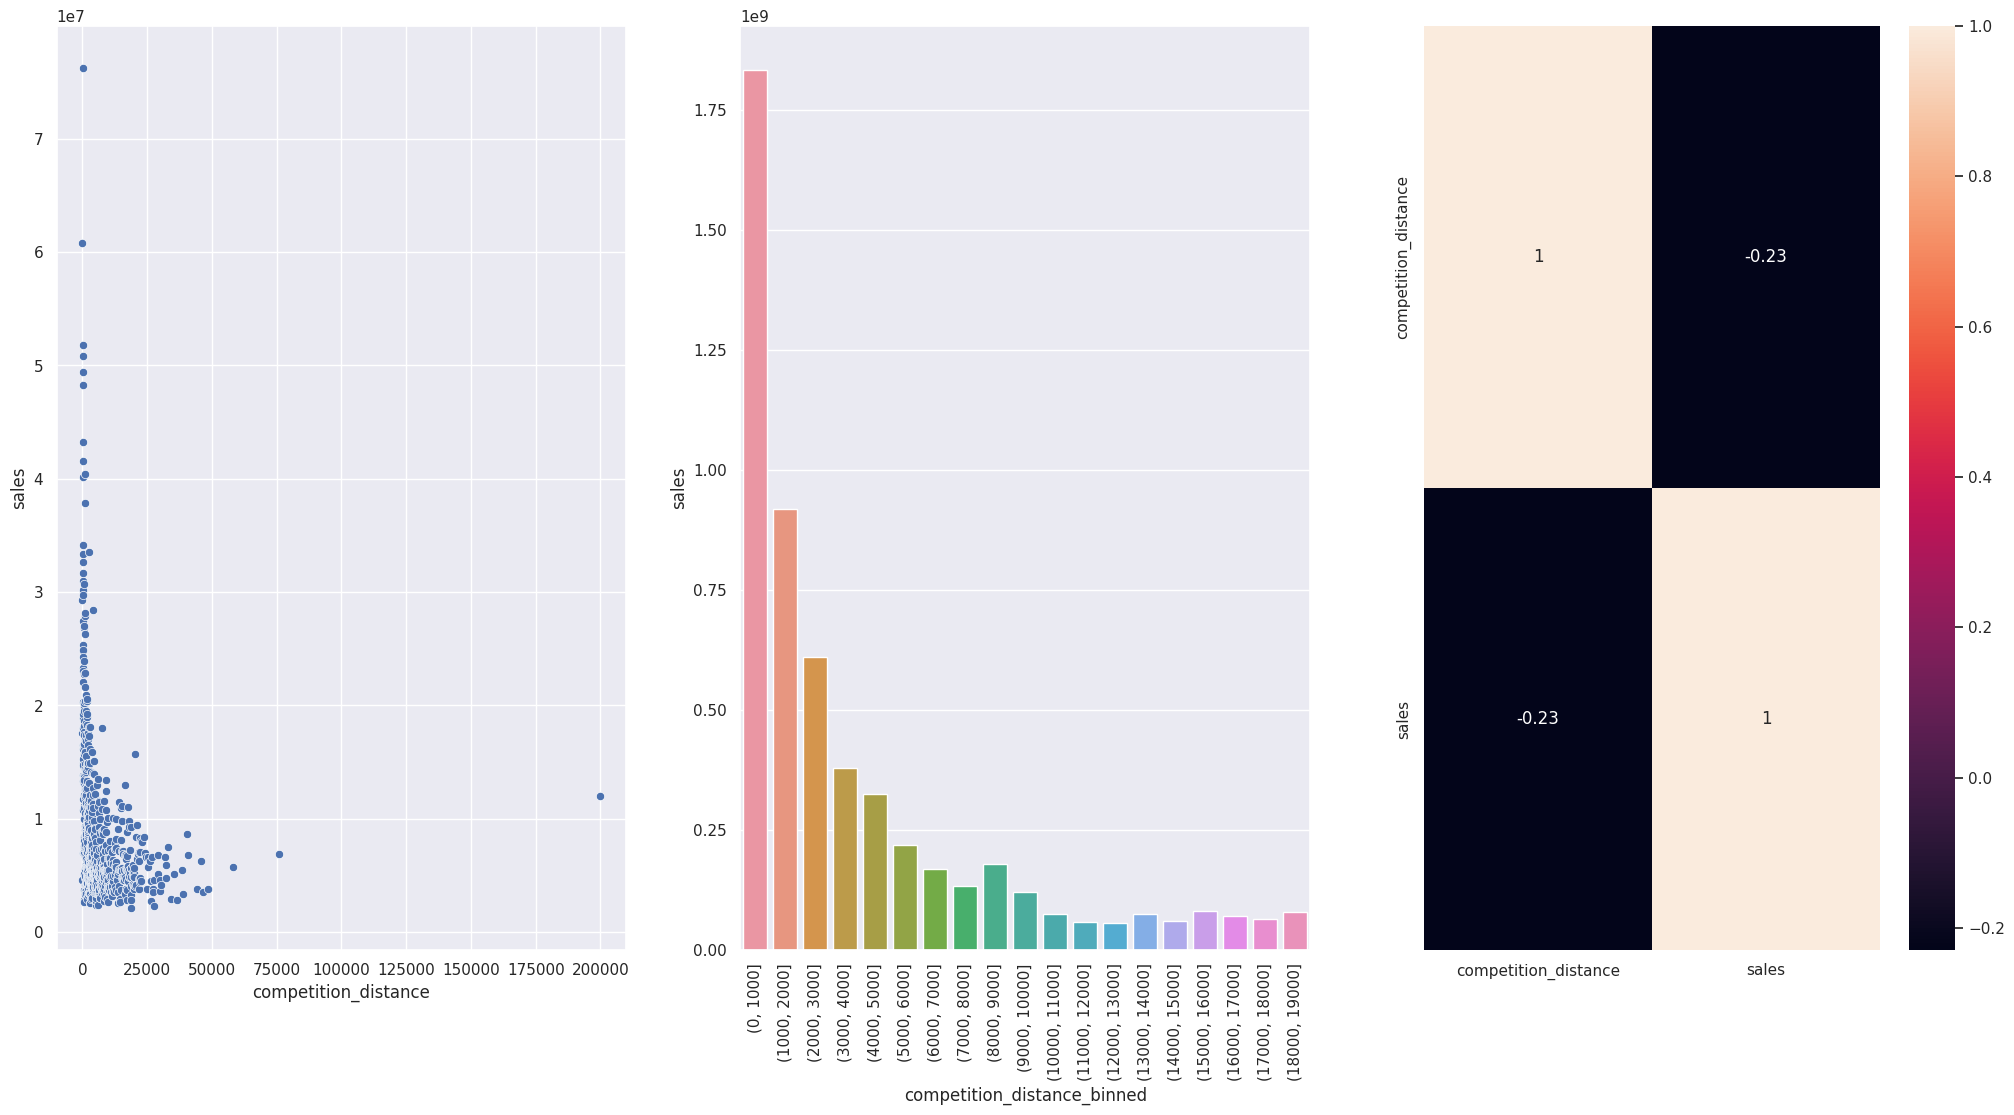

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data = aux1, x='competition_distance', y='sales');

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores há mais tempo deveriam vender mais.
**FALSA** Lojas com competidores há mais tempo vendem menos.

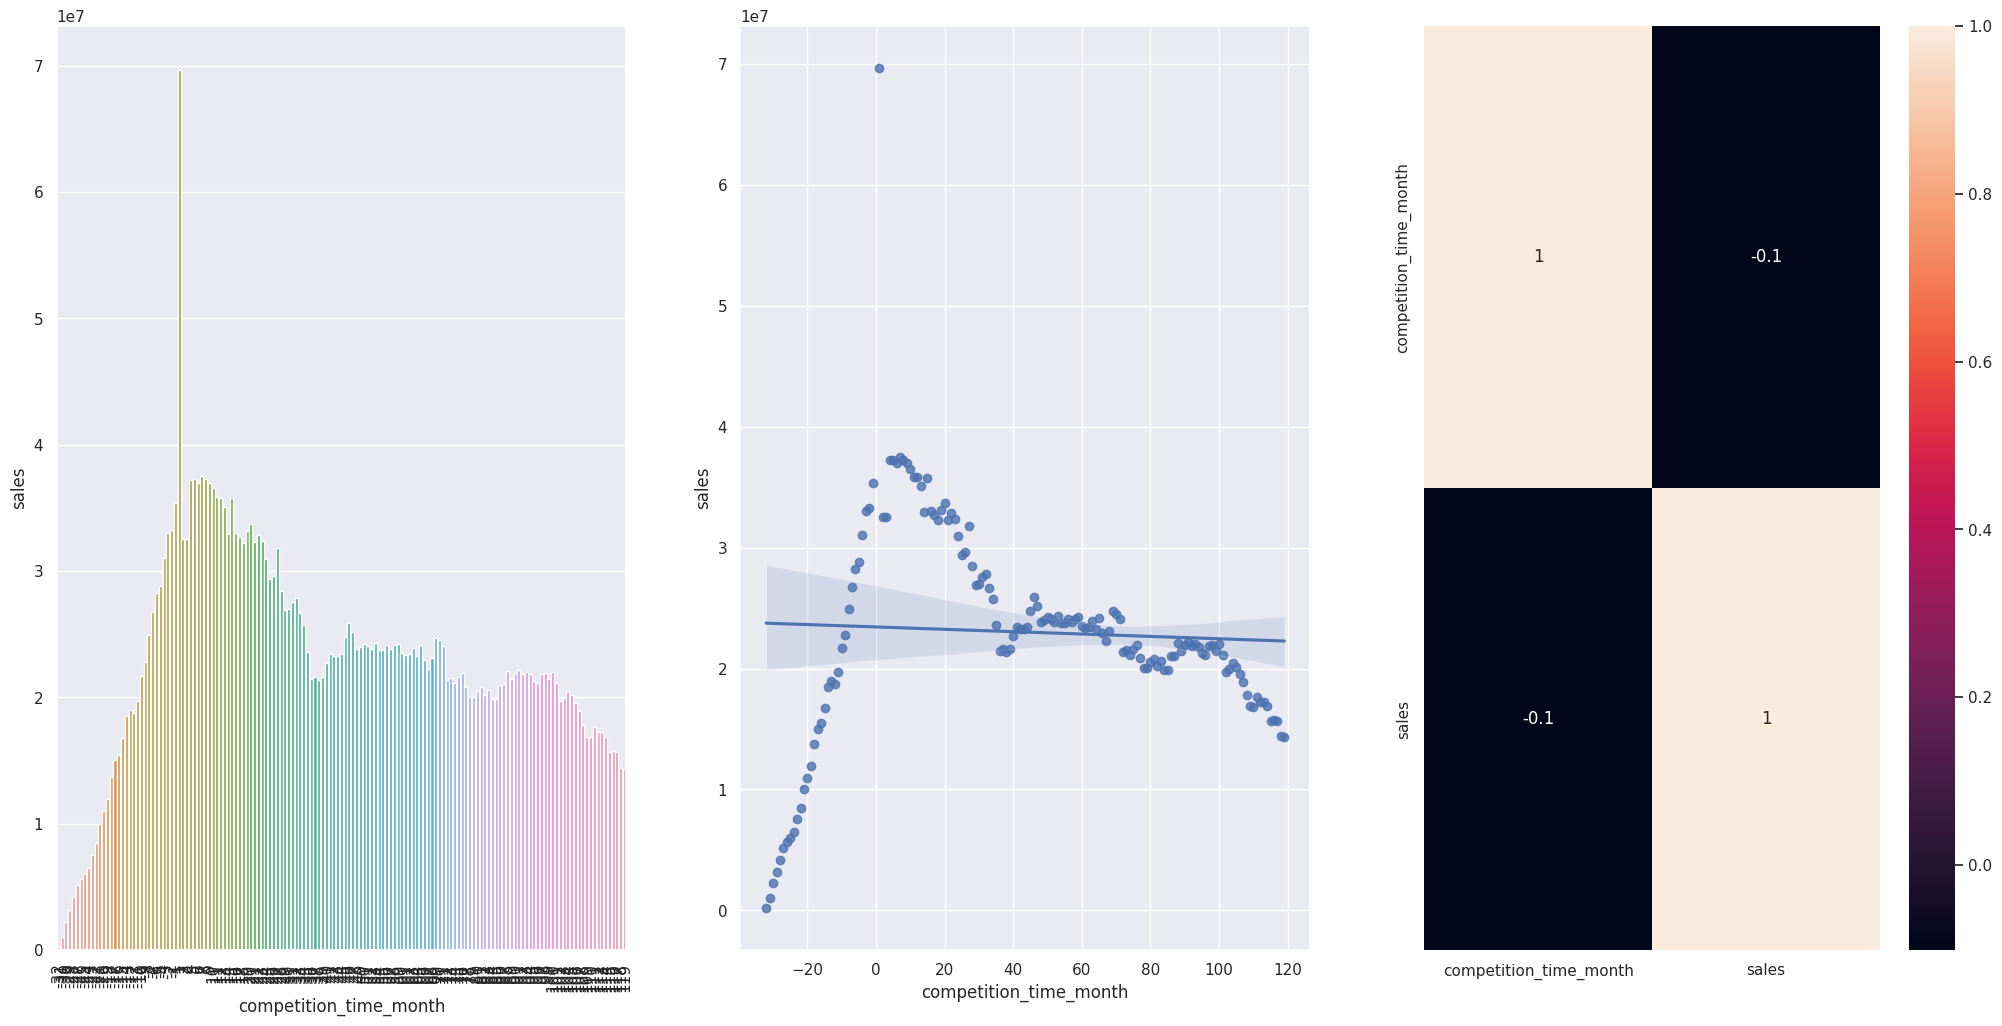

In [30]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** porque lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

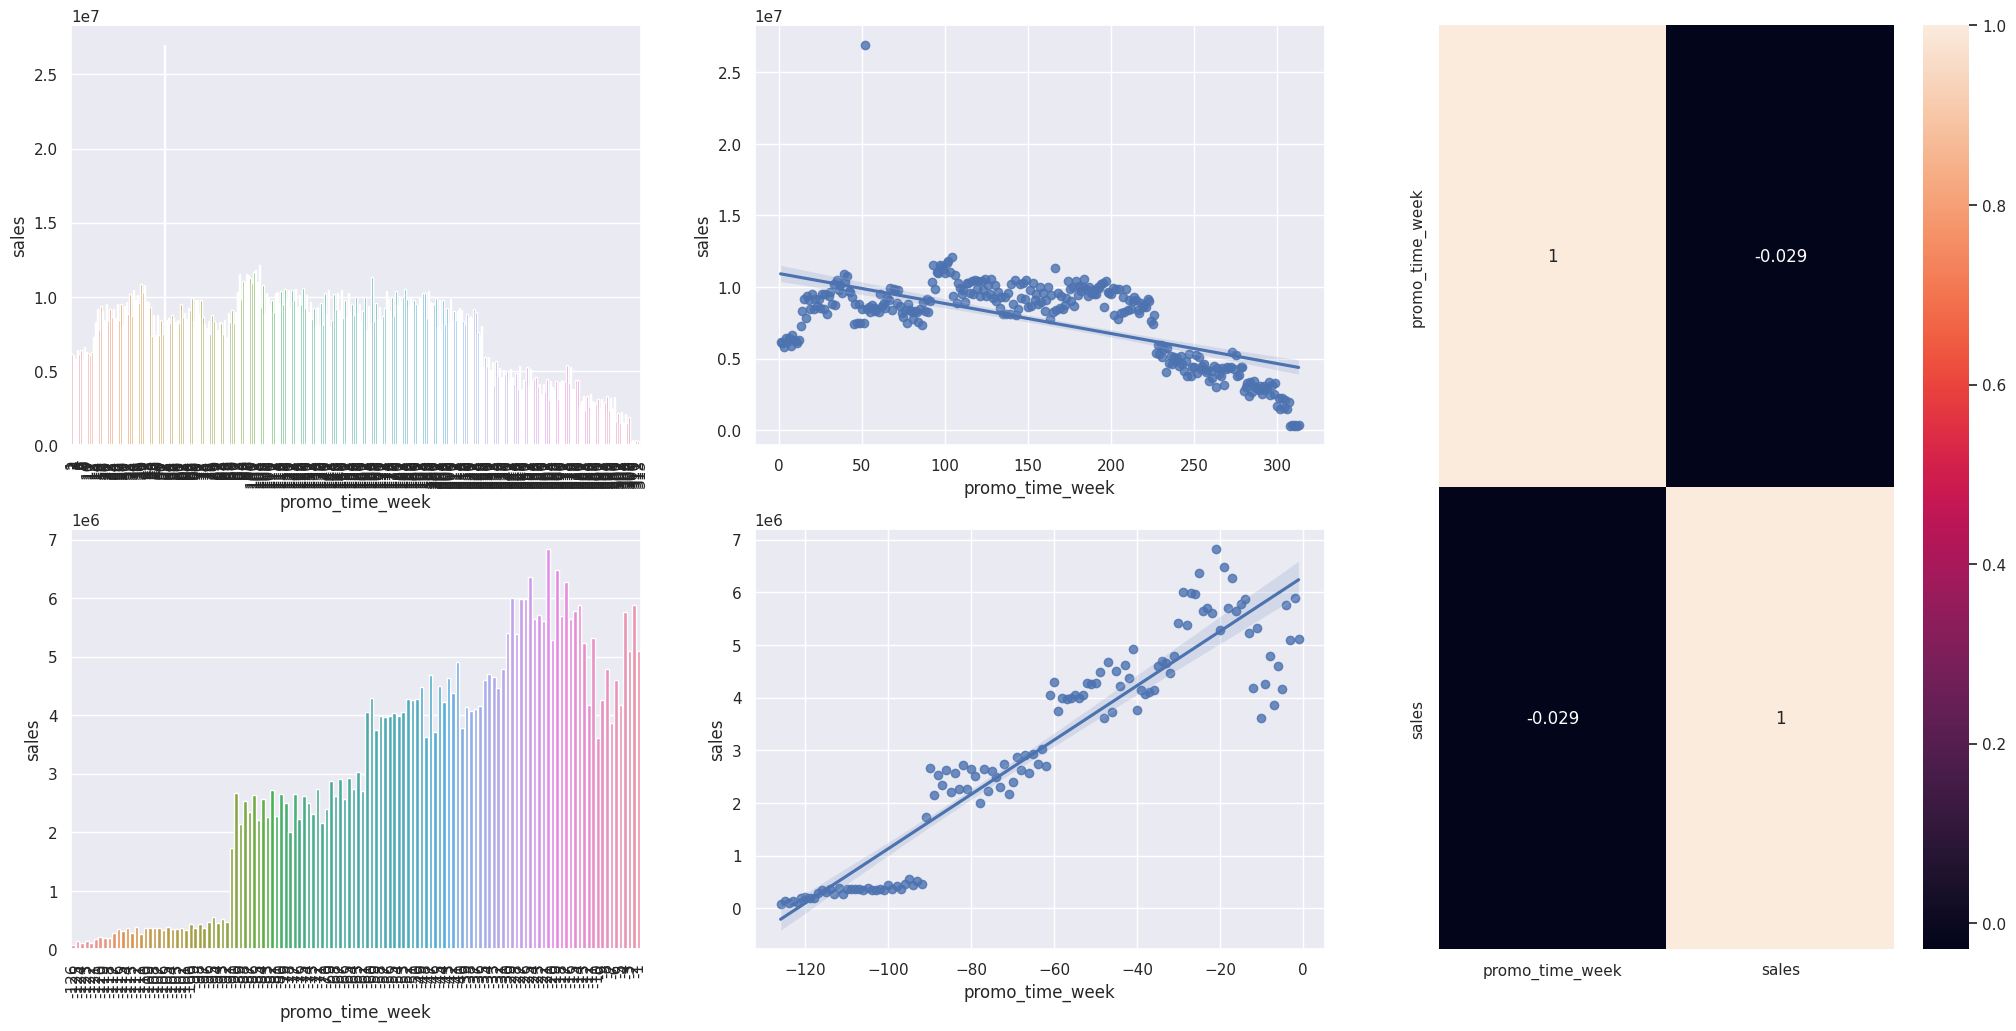

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(data = aux2, x = 'promo_time_week', y = 'sales');
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(data = aux2, x = 'promo_time_week', y = 'sales');

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(data = aux3, x = 'promo_time_week', y = 'sales');
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(data = aux3, x = 'promo_time_week', y = 'sales');

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [32]:
df4.sample(10).T

,19563,681835,474931,24338,308983,103005,999805,953409,117654,876261
store,609,241,727,924,733,426,436,870,580,657
day_of_week,2,1,5,5,3,4,3,3,5,2
date,2015-07-14 00:00:00,2013-10-28 00:00:00,2014-05-02 00:00:00,2015-07-10 00:00:00,2014-10-15 00:00:00,2015-04-30 00:00:00,2013-01-16 00:00:00,2013-02-27 00:00:00,2015-04-17 00:00:00,2013-05-07 00:00:00
sales,4822,4607,7750,4181,11284,6151,3963,6422,9647,3914
promo,1,0,1,0,0,1,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,1,1,0,0,0,1,0
store_type,a,d,a,a,b,a,d,a,a,c
assortment,basic,extended,basic,basic,extra,basic,basic,basic,extended,extended
competition_distance,2070.0,780.0,2050.0,6420.0,860.0,250.0,2300.0,780.0,170.0,80.0


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** porque lojas com mais promoções consecutivas vendem menos.

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


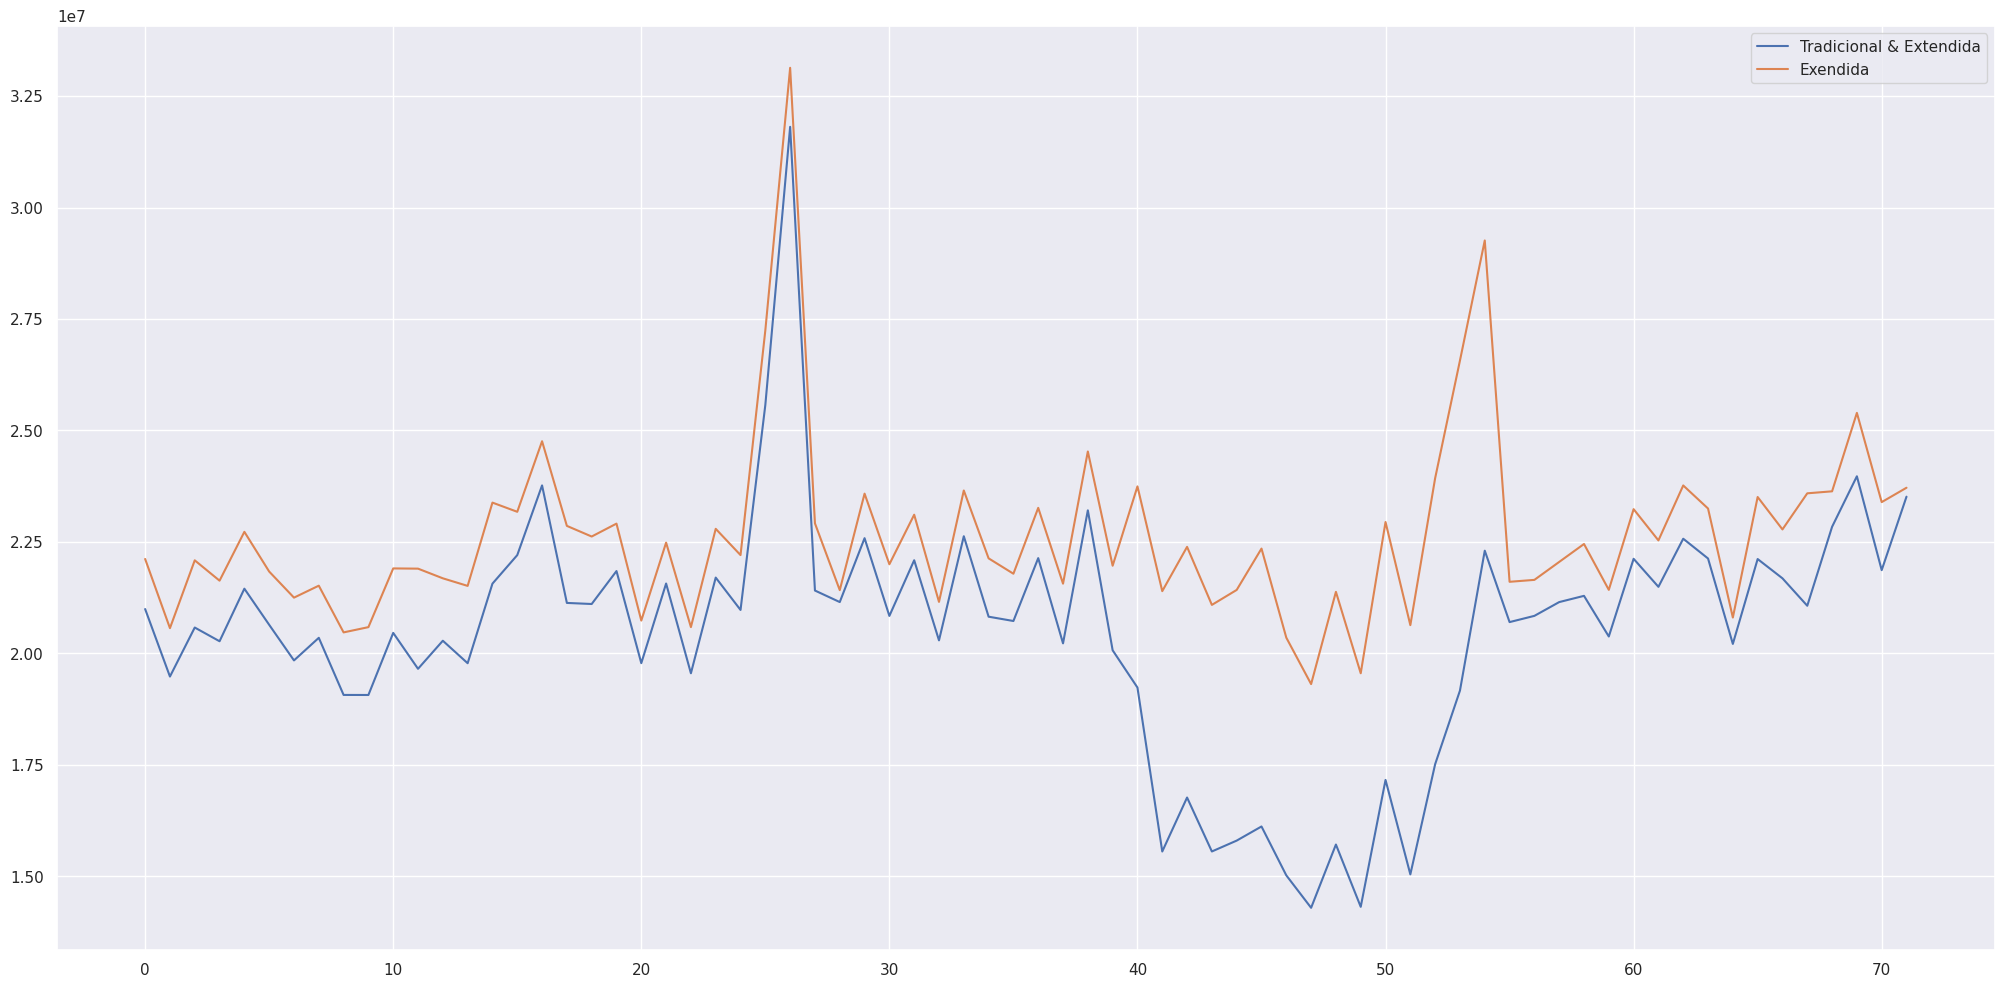

In [34]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Exendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** porque lojas abertas durante o feriado do Natal vendem menos.

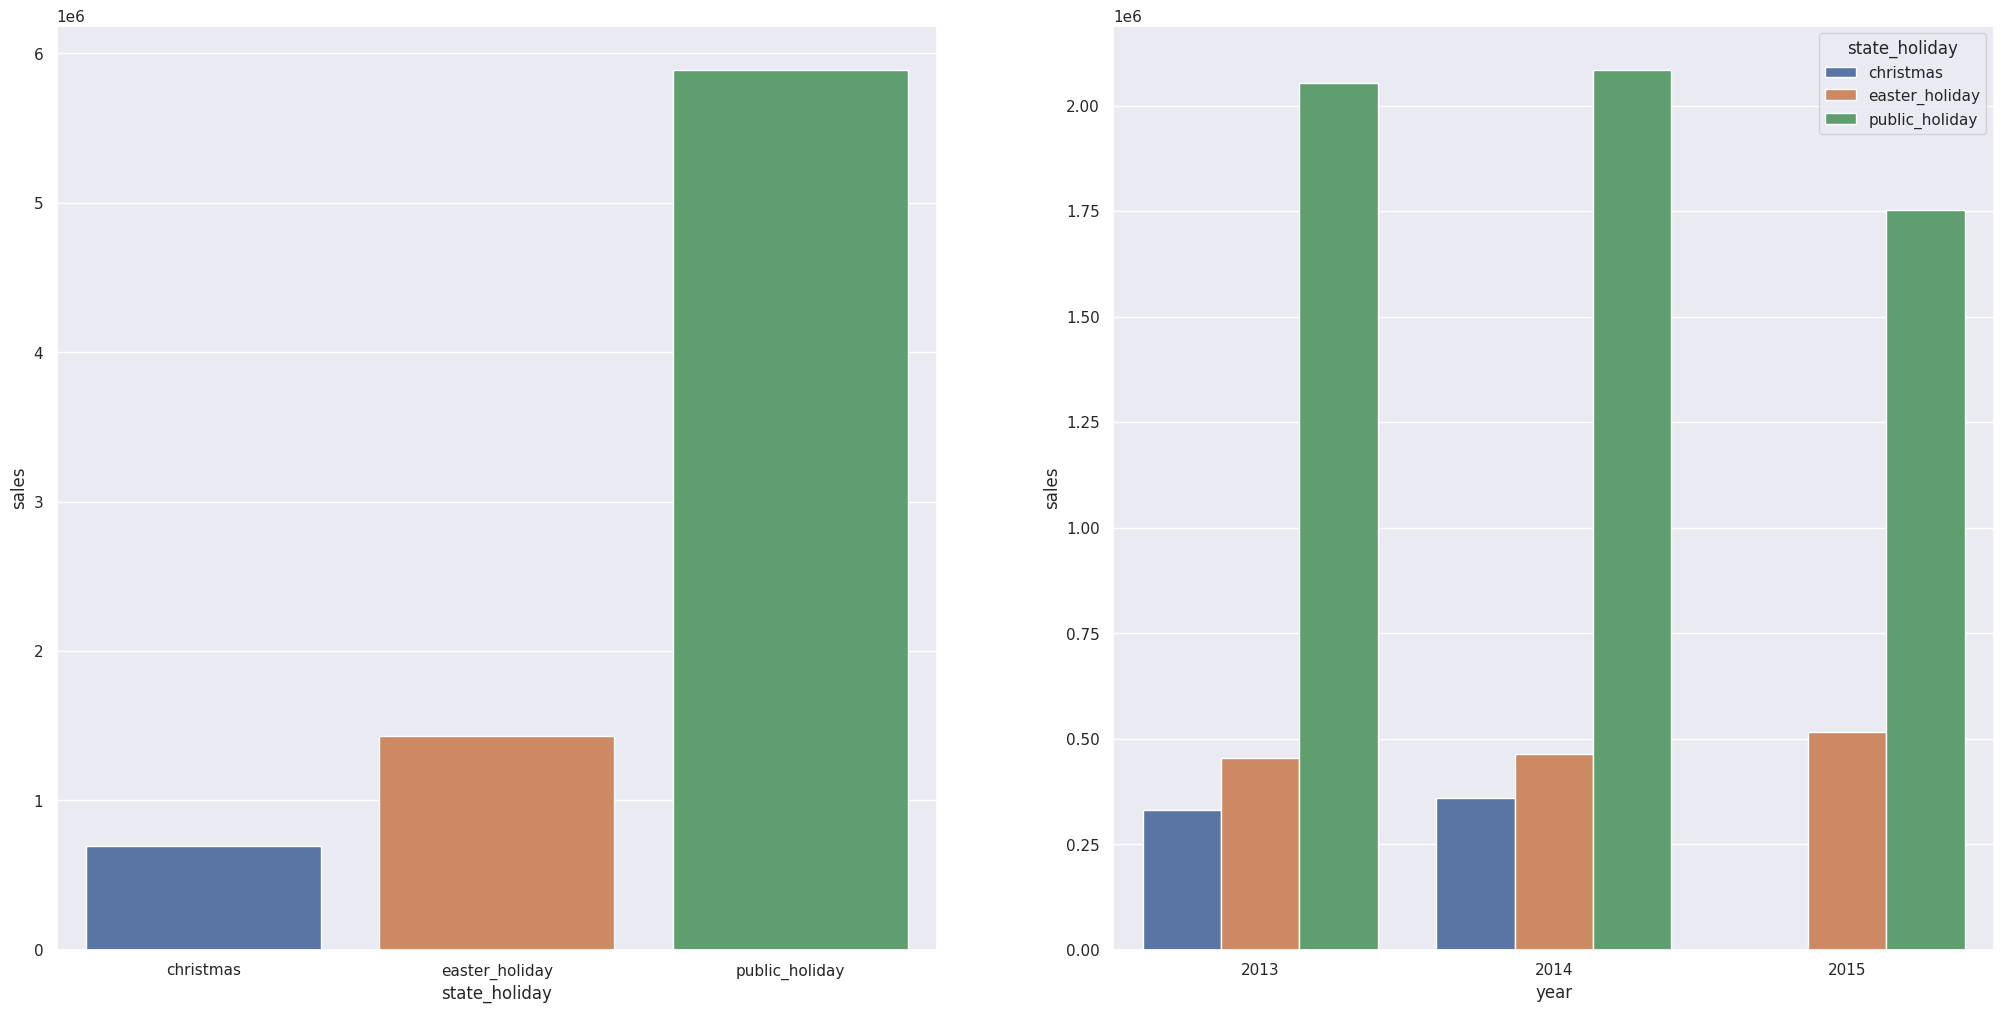

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux1, x='state_holiday', y='sales');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday');

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** porque lojas vendem menos ao longo dos anos.

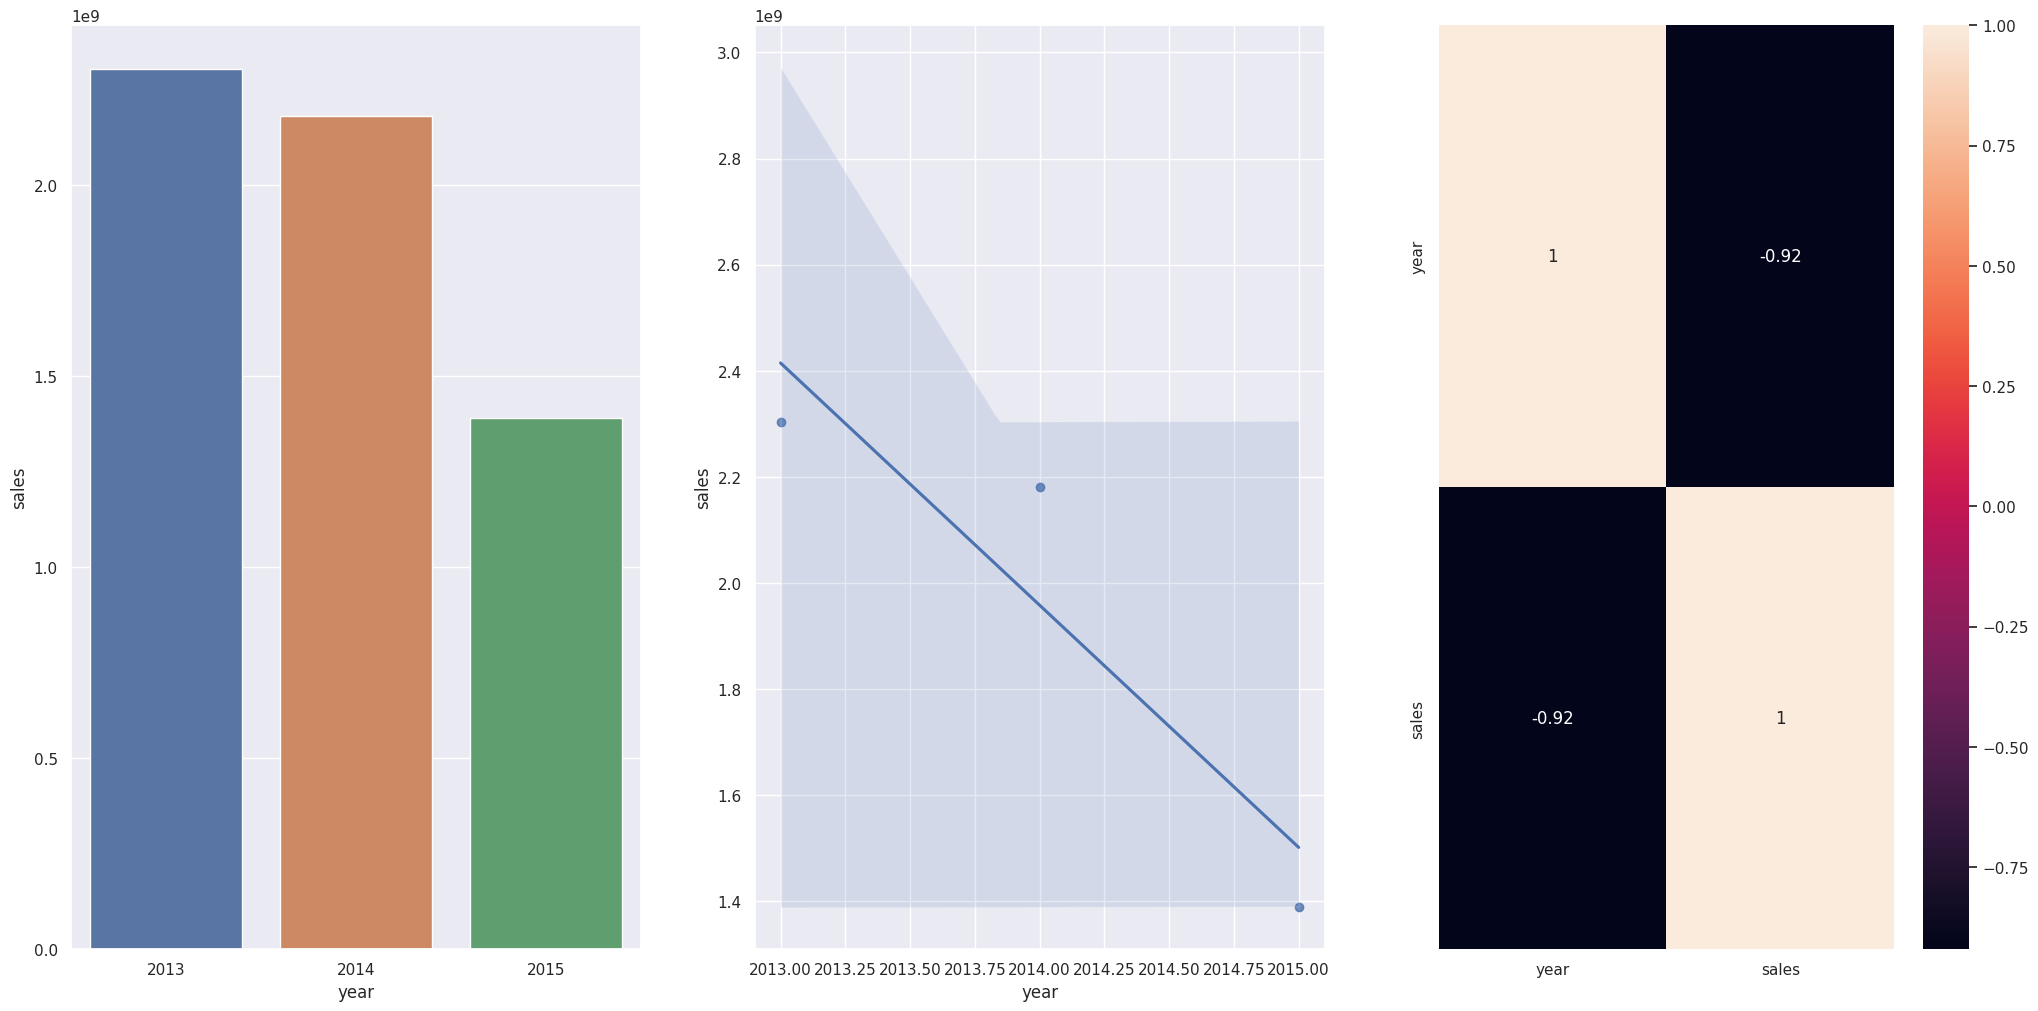

In [36]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='year', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='year', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** porque lojas vendem menos no segundo semestre do ano.

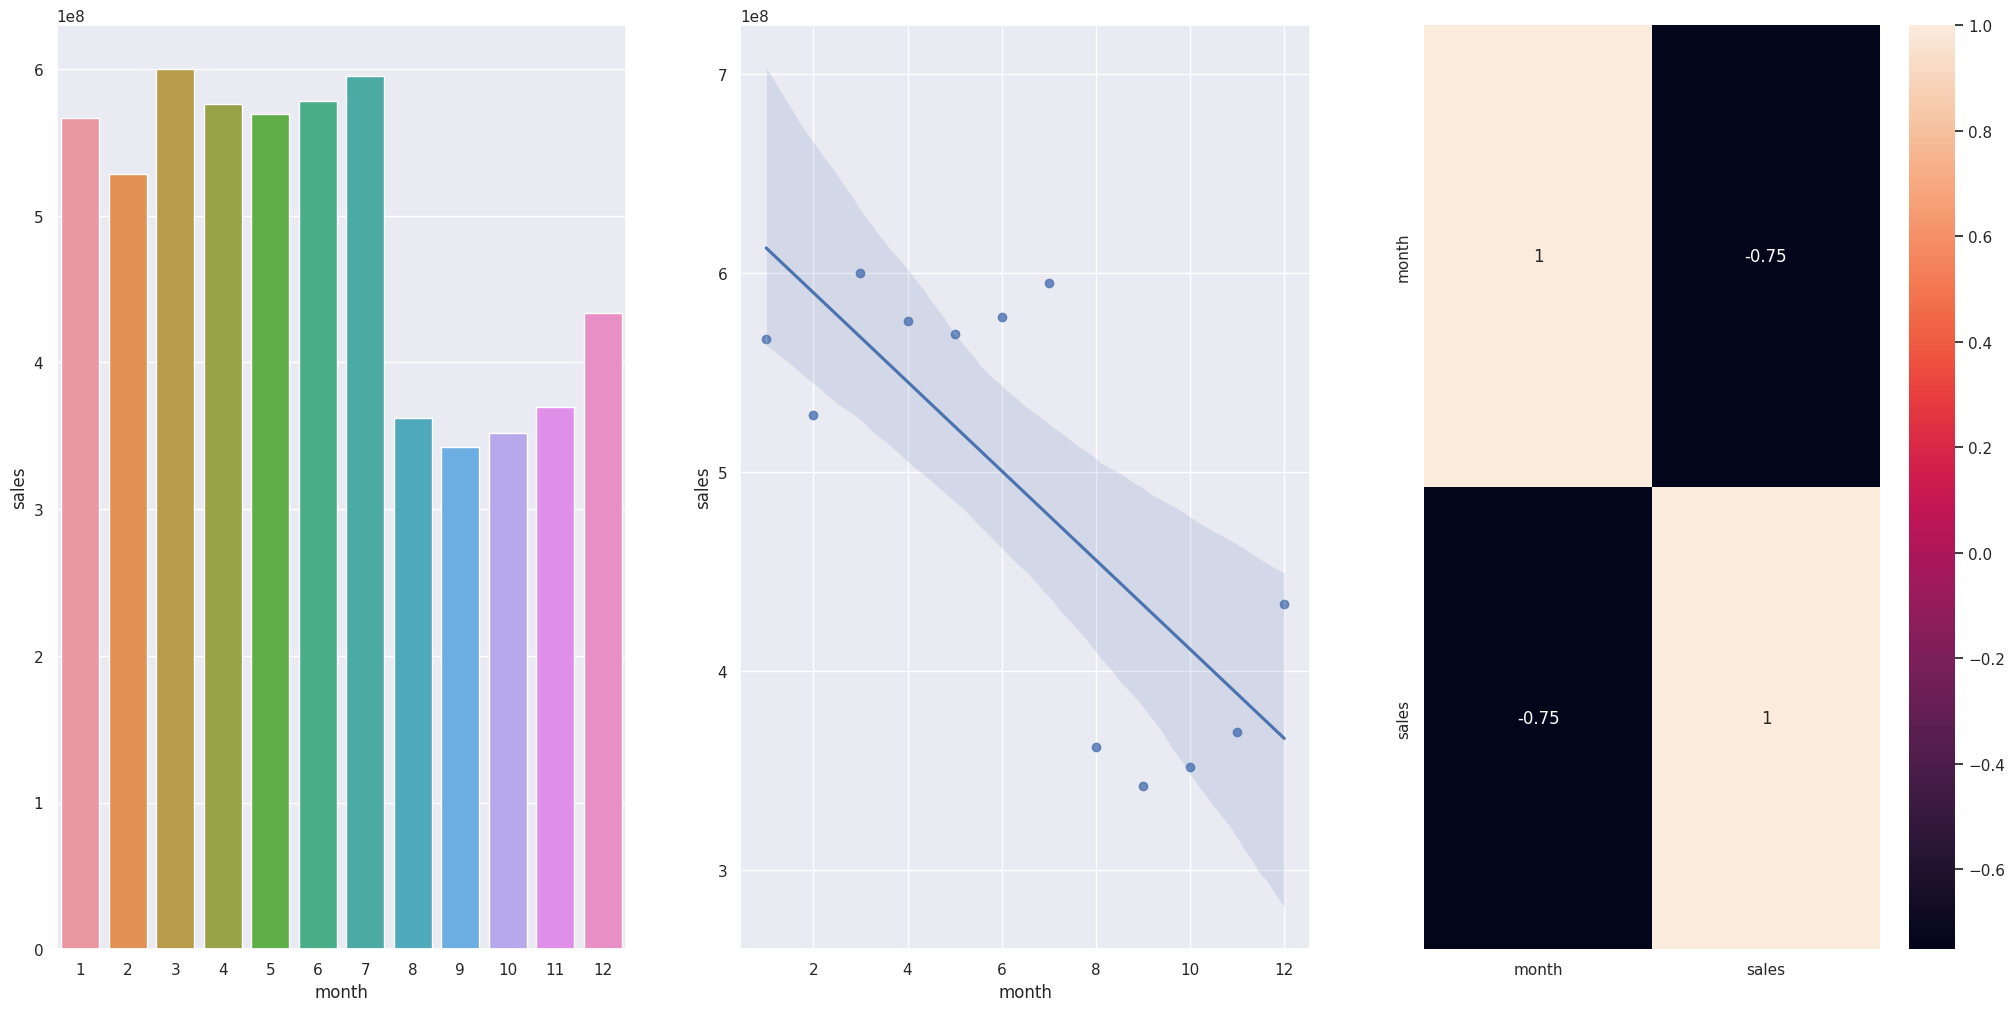

In [37]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='month', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** porque lojas vendem mais depois do dia 10 de cada mês. 

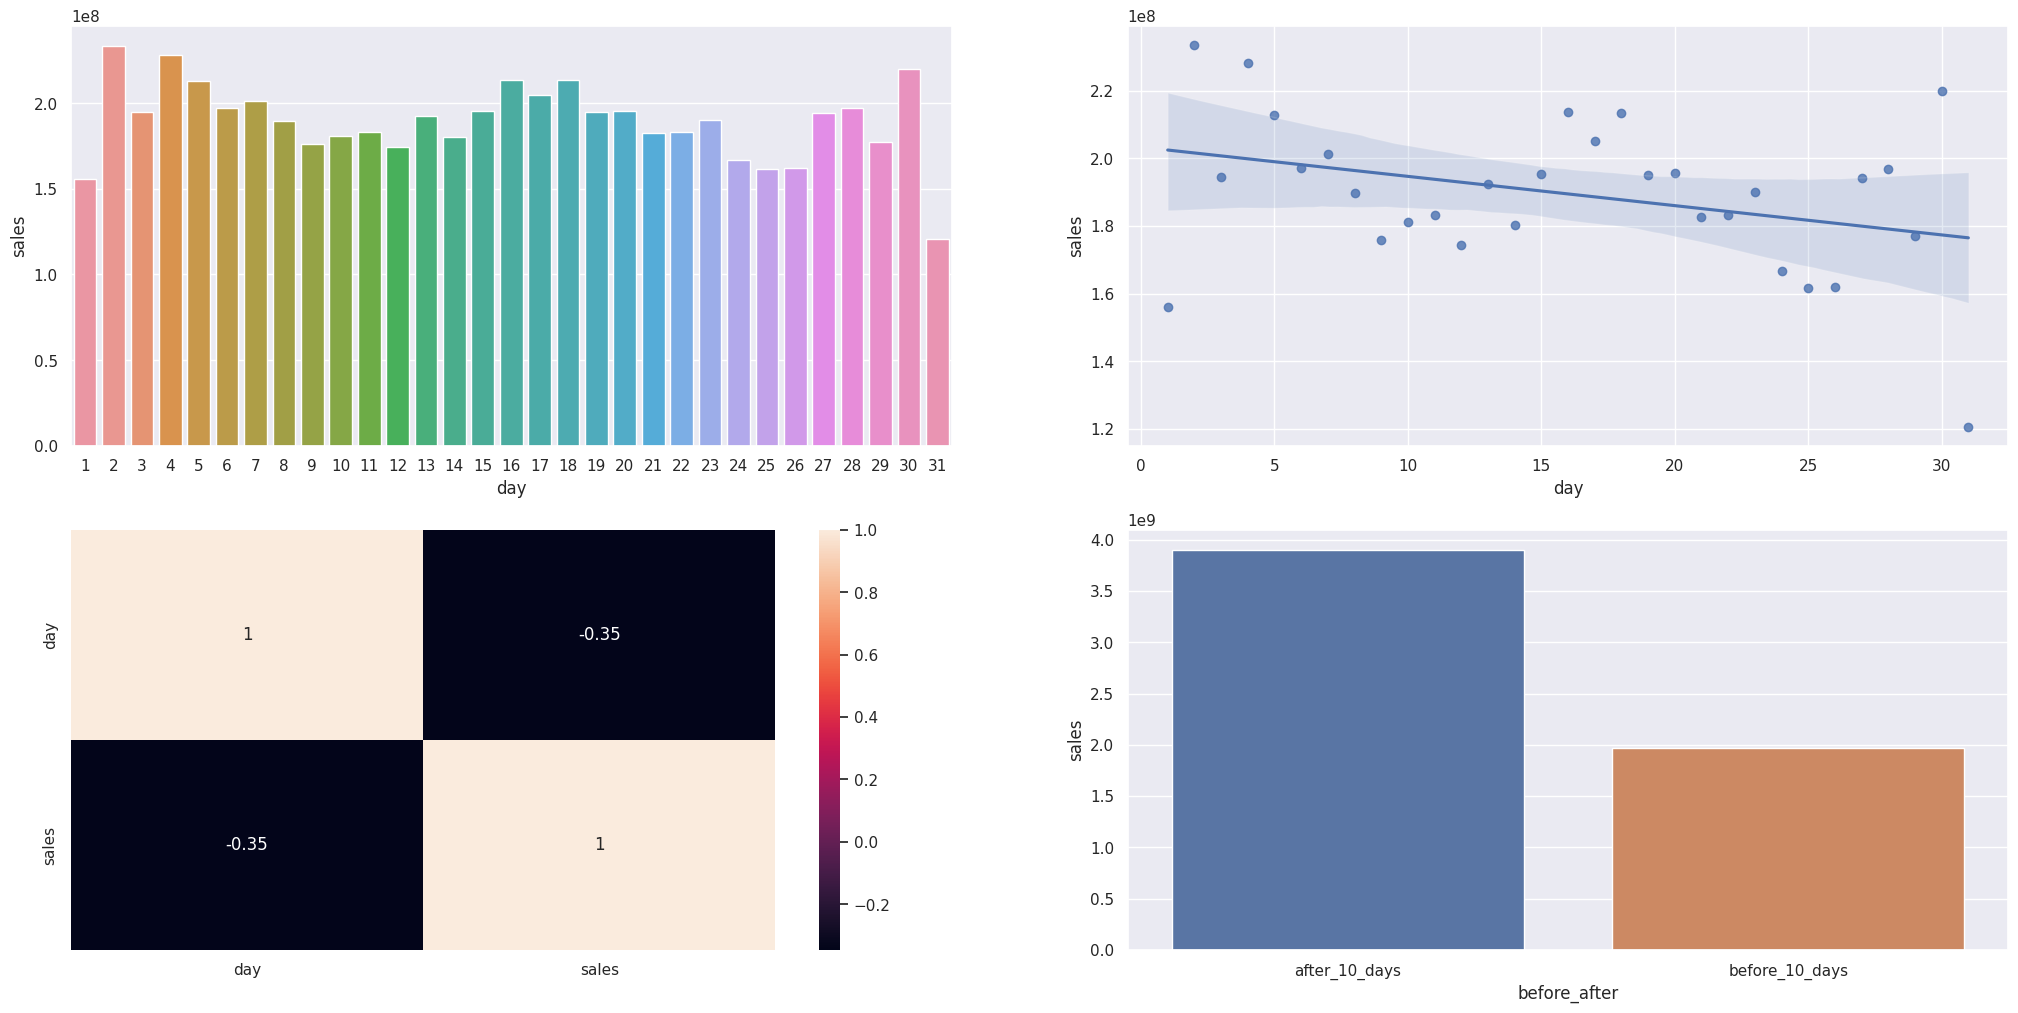

In [38]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sales');

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** porque lojas vendem menos nos finais de semana.

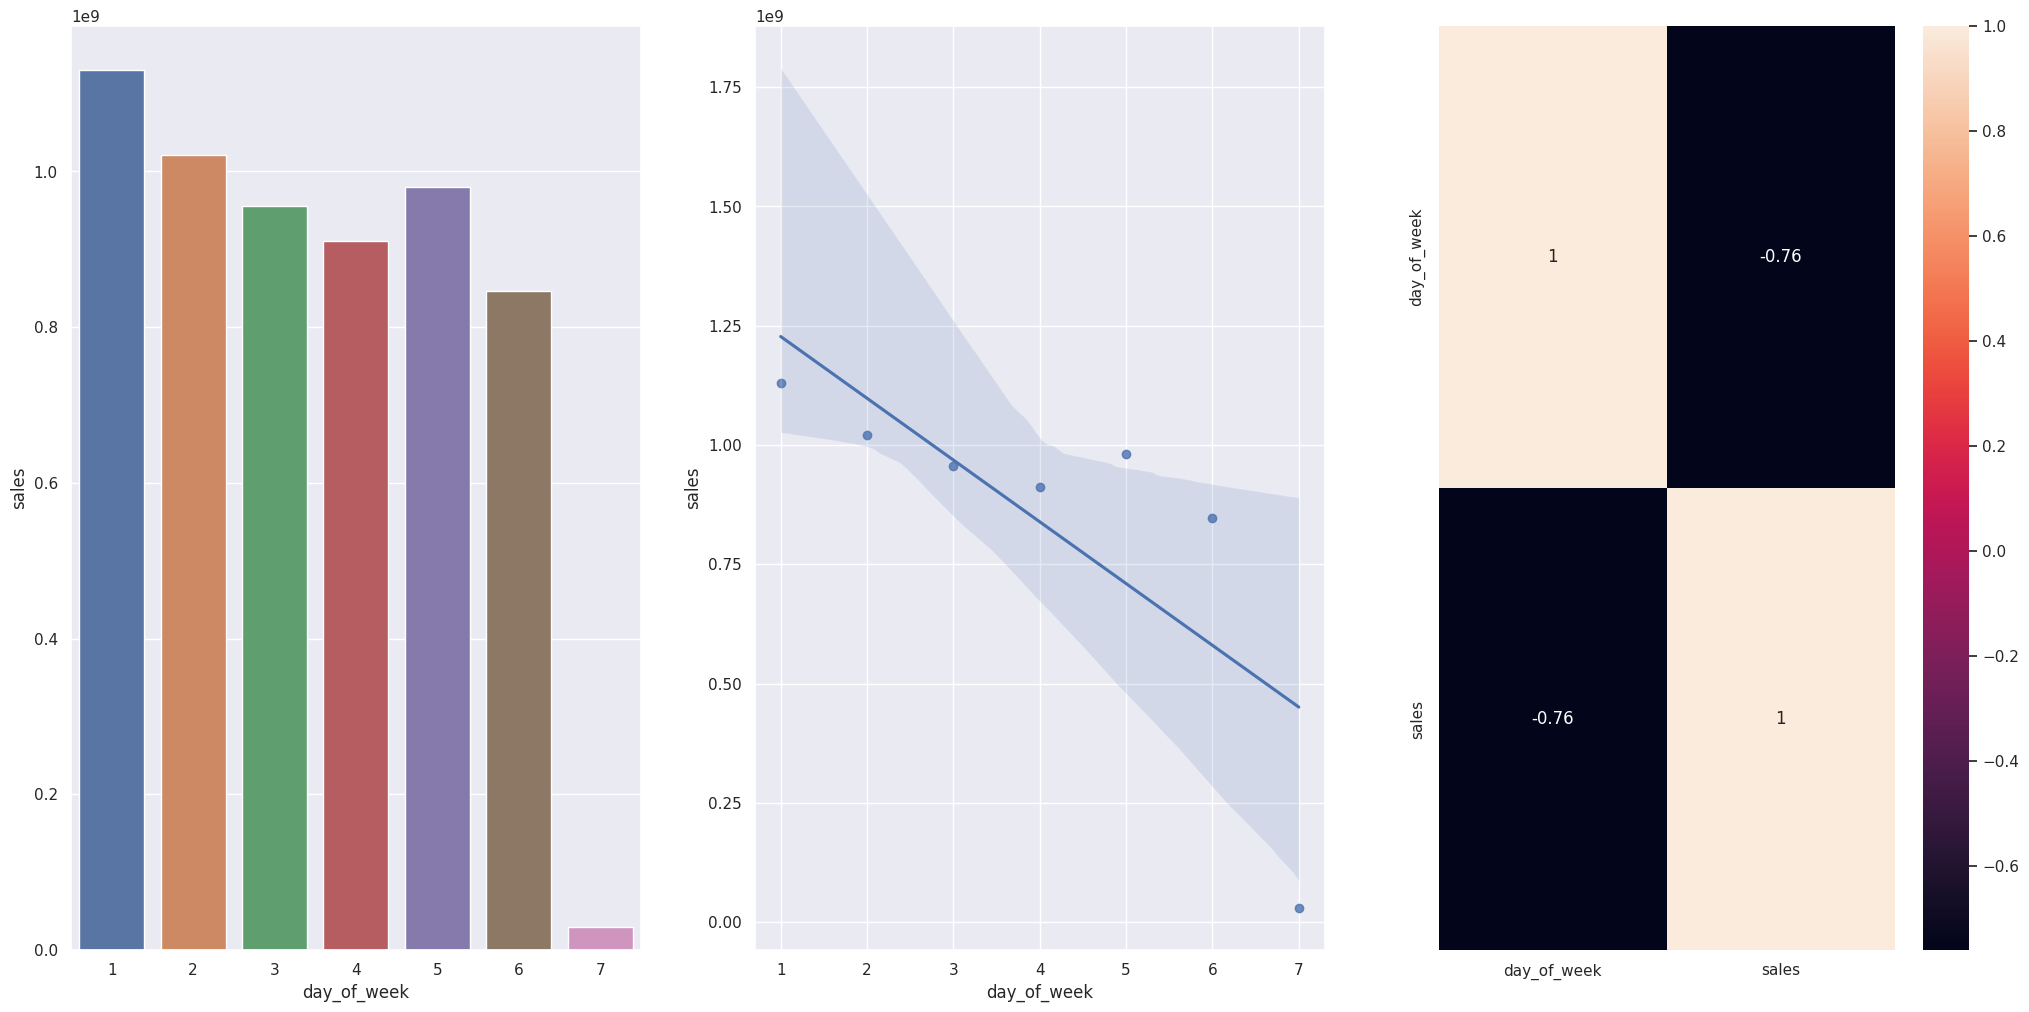

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** porque lojas vendem menos durante feriados escolares, exceto nos meses de julho e agosto.

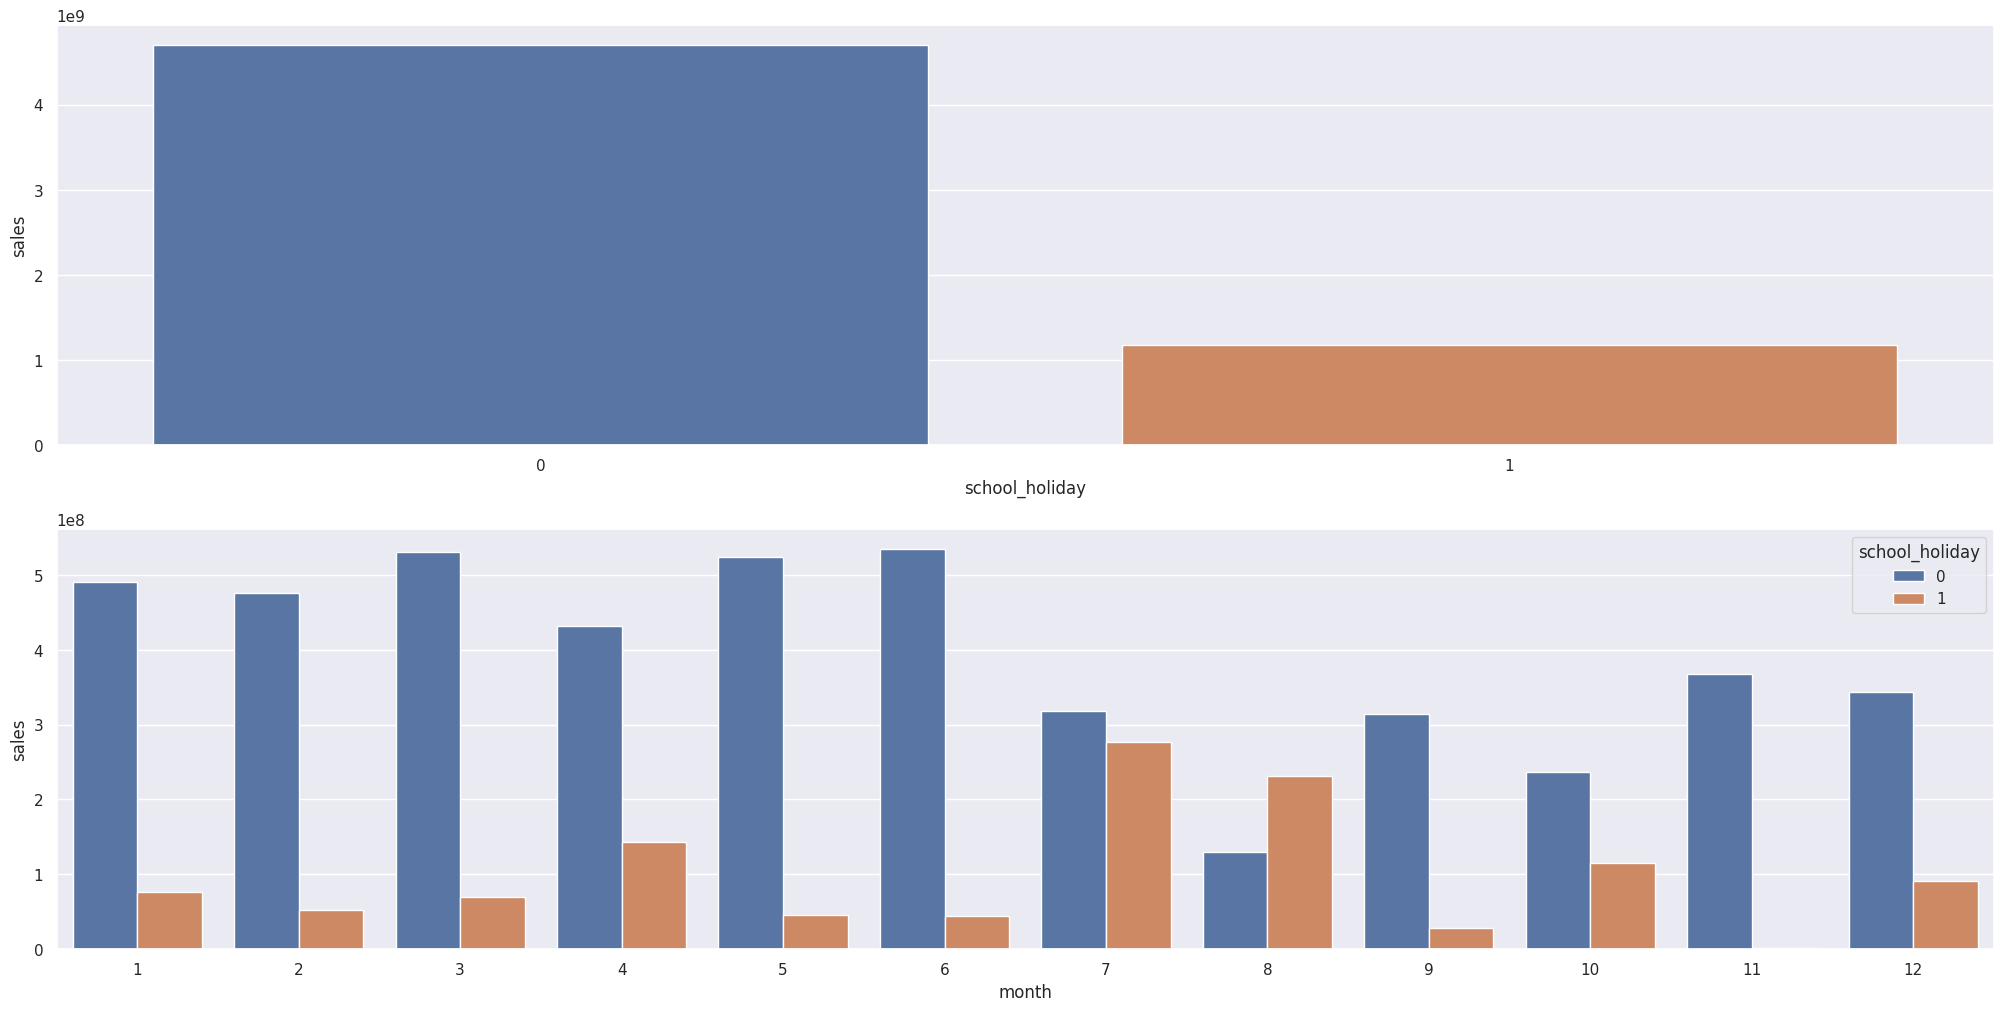

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(data=aux1, x='school_holiday', y='sales');

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

### 4.2.1. Resumo das Hipóteses

In [41]:
from tabulate import tabulate

In [42]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

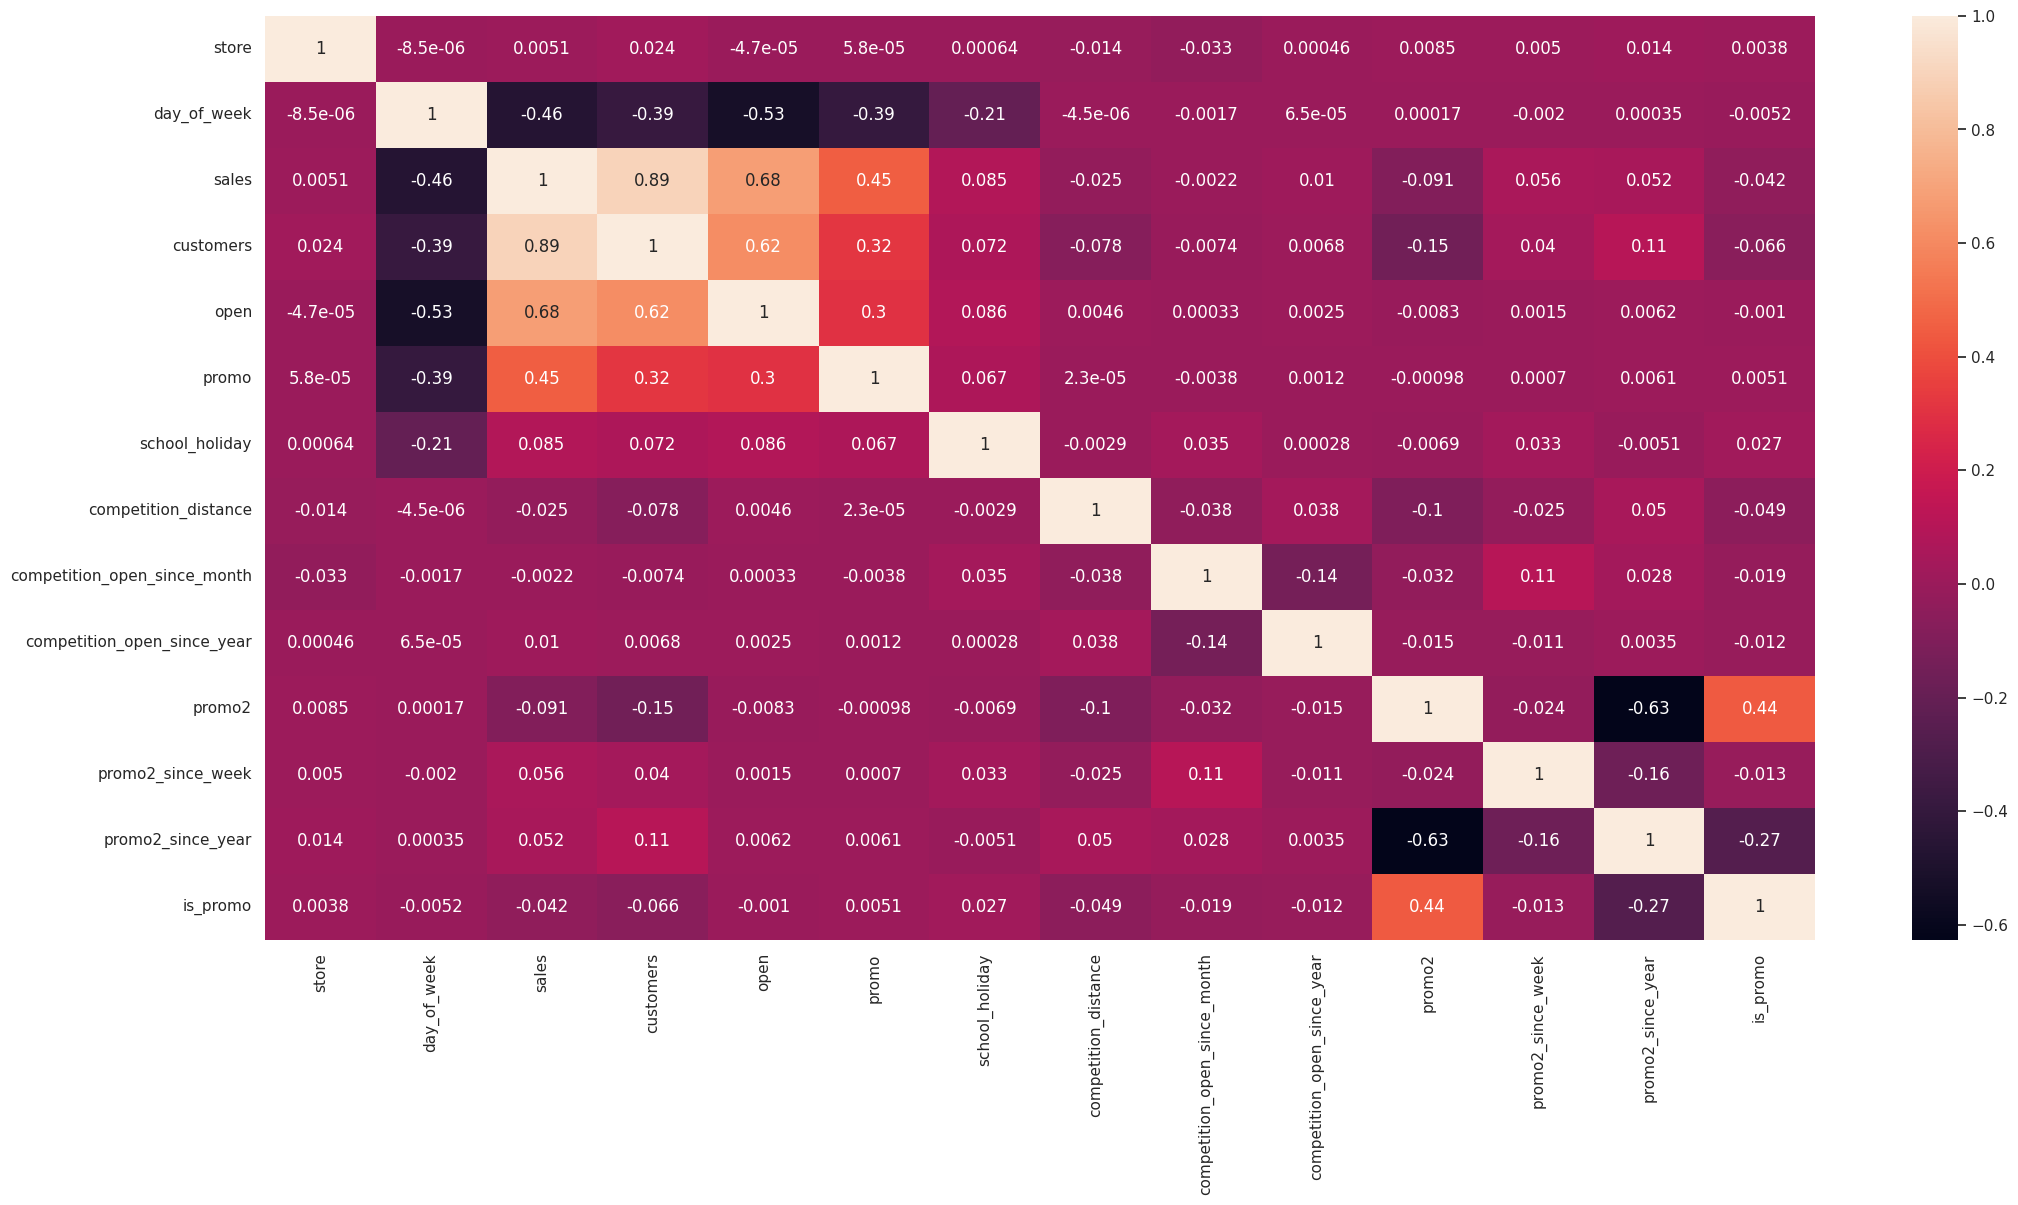

In [43]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Atributos Categóricos

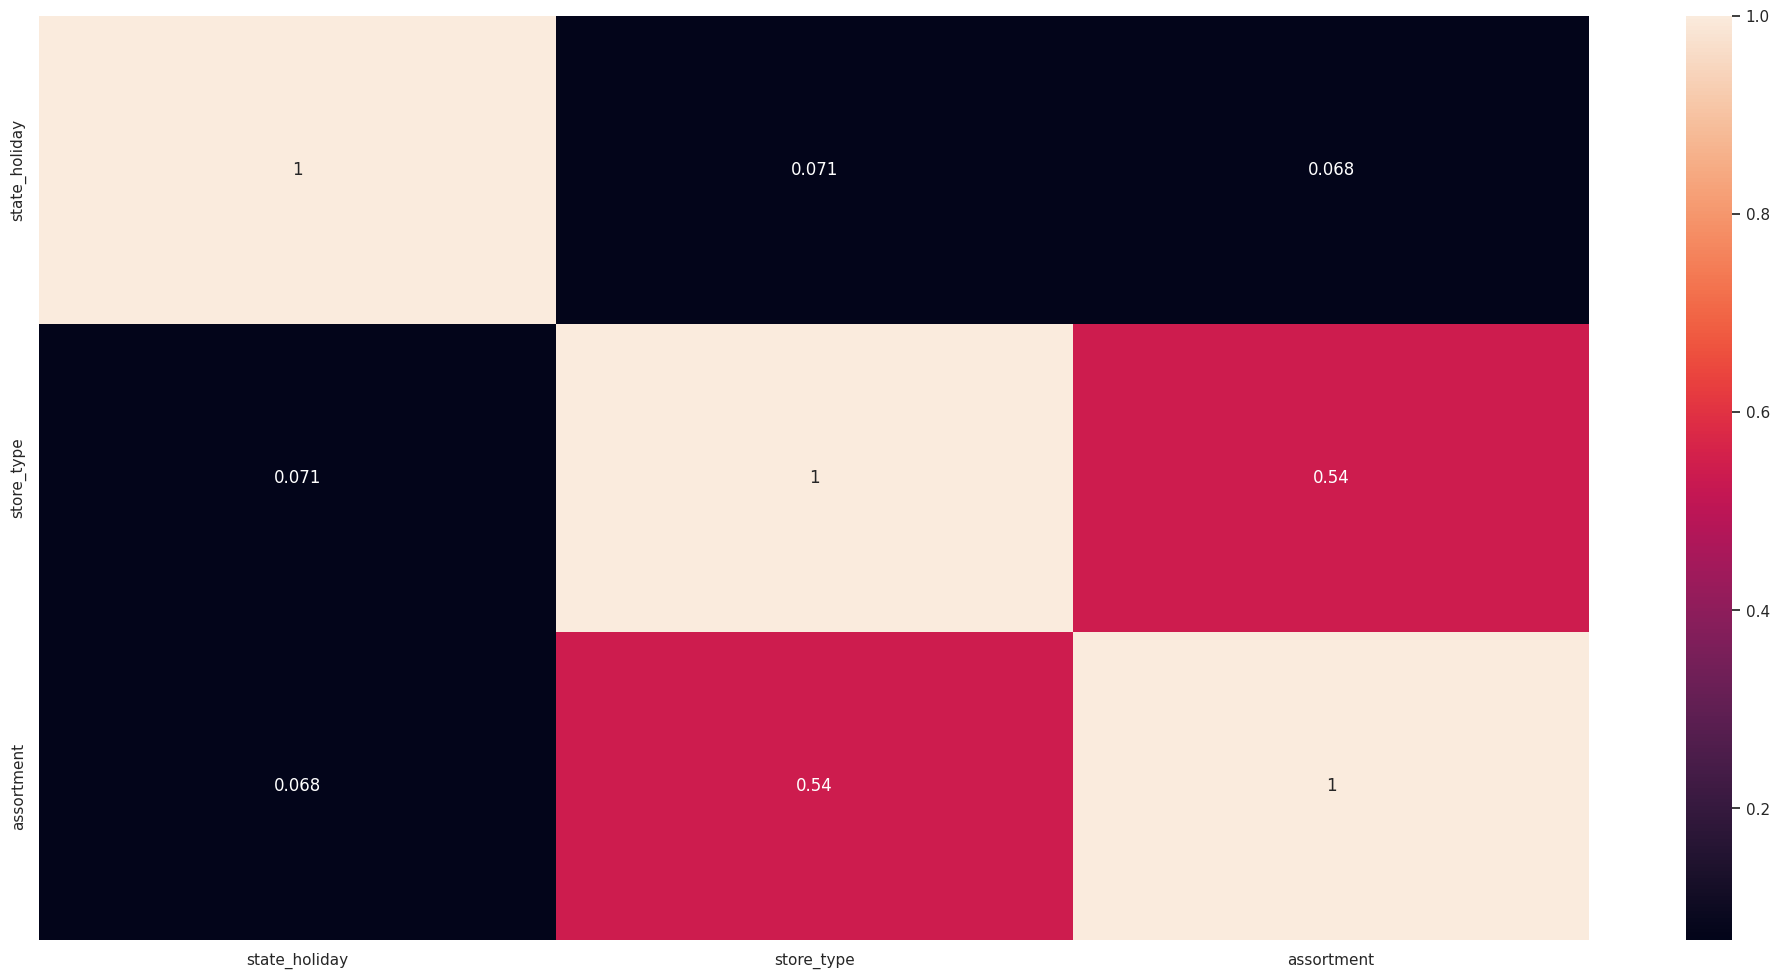

In [44]:
# somente variáveis categóricas
a = df4.select_dtypes(include='object')

# cálculo cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0. PREPARAÇÃO DOS DADOS

In [45]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [46]:
#a = df5.select_dtypes(include=['int64', 'float64'])
#sns.boxplot(df5['promo_time_week'], orient='h')

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3. Transformação

### 5.3.1. Encoding

In [48]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da variável resposta

In [49]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Transformação de natureza

In [50]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# 6.0. SELEÇÃO DE FEATURES

In [51]:
df6 = df5.copy()

## 6.1. Divisão do dataframe entre treino e teste

In [52]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [53]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [54]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta (seleção de features)

In [55]:
# treino e teste para o Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Melhores features segundo Boruta

In [56]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

## 6.3. Seleção manual de features

In [57]:
cols_selected_boruta = [
    'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# adicionar colunas
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [58]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. MACHINE LEARNING MODELLING

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação da Time Series
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [60]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, how='left', on='store')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

In [61]:
# baseline_result

## 7.2. Linear Regression Model

In [62]:
# # model
# lr = LinearRegression().fit(x_train, y_train)

# # prediction
# yhat_lr = lr.predict(x_test)

# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [63]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
# lr_result_cv

## 7.3. Linear Regression Regularized Model

In [64]:
# # model
# lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# # prediction
# yhat_lrr = lrr.predict(x_test)

# # performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Linear Regression Regularized Model (Lasso) - Cross Validation

In [65]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
# lrr_result_cv

## 7.4. Random Forest Regressor

In [66]:
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [67]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv

## 7.5. XGBoost Regressor

In [68]:
# # model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                              n_estimators=100, 
#                              eta=0.01, 
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)

# # prediction
# yhat_xgb = model_xgb.predict(x_test)

# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [69]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
# xgb_result_cv

## 7.6. Comparação de Performance dos Modelos

### 7.6.1 Performance Única

In [70]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2 Performance Real - Cross Validation

In [71]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result_cv

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [72]:
# param = {
#          'n_estimators':[1500, 1700, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'max_depth':[3, 5, 9],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytree':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15]
#          }

# MAX_EVAL = 10

In [73]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):

#   # choose values for parameter randomly
#   hp = {k: sample(v, 1)[0] for k, v in param.items()}
#   print(hp)

#   # model
#   model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                               n_estimators=hp['n_estimators'], 
#                               eta=hp['eta'], 
#                               max_depth=hp['max_depth'],
#                               subsample=hp['subsample'],
#                               colsample_bytree=hp['colsample_bytree'],
#                               min_child_weight=hp['min_child_weight'])

#   # performance
#   result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#   final_result = pd.concat([final_result, result])

# final_result

## 8.2. Final Model

In [74]:
param_tuned = {
         'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 3
         }

In [75]:
# # model
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
#                                    n_estimators=param_tuned['n_estimators'], 
#                                    eta=param_tuned['eta'], 
#                                    max_depth=param_tuned['max_depth'],
#                                    subsample=param_tuned['subsample'],
#                                    colsample_bytree=param_tuned['colsample_bytree'],
#                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # performance
# xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# xgb_result_tuned

In [76]:
#mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

### 8.2.1 Pickle

In [77]:
# pickle.dump(model_xgb_tuned, open('/content/drive/MyDrive/Colab Notebooks/ds_em_producao/model/model_rossmann.pkl', 'wb'))
# pickle.dump(yhat_xgb_tuned, open('/content/drive/MyDrive/Colab Notebooks/ds_em_producao/model/yhat_xbg_tuned_rossmann.pkl', 'wb'))

In [78]:
# load model
# model_open = open('model/model_rossmann.pkl', 'rb')
# model_xgb_tuned = pickle.load(model_open)
model_xgb_tuned = xgb.Booster()
model_xgb_tuned.load_model("model/model_rossmann3.bin")

# load yhat
yhat_open = open('model/yhat_xbg_tuned_rossmann.pkl', 'rb')
yhat_xgb_tuned = pickle.load(yhat_open)

[14:17:56] WARNING: ../src/learner.cc:940: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [79]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/tmp/ipykernel_3038/1540074760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_3038/1540074760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1. Business Performance


In [80]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [81]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105213.437500,101904.130924,108522.744076,3309.306576,0.567223
908,909,236345.234375,228686.412385,244004.056365,7658.821990,0.513971
594,595,371568.593750,367307.934082,375829.253418,4260.659668,0.297058
875,876,200504.234375,196634.194102,204374.274648,3870.040273,0.291588
721,722,351693.656250,349736.963049,353650.349451,1956.693201,0.261596


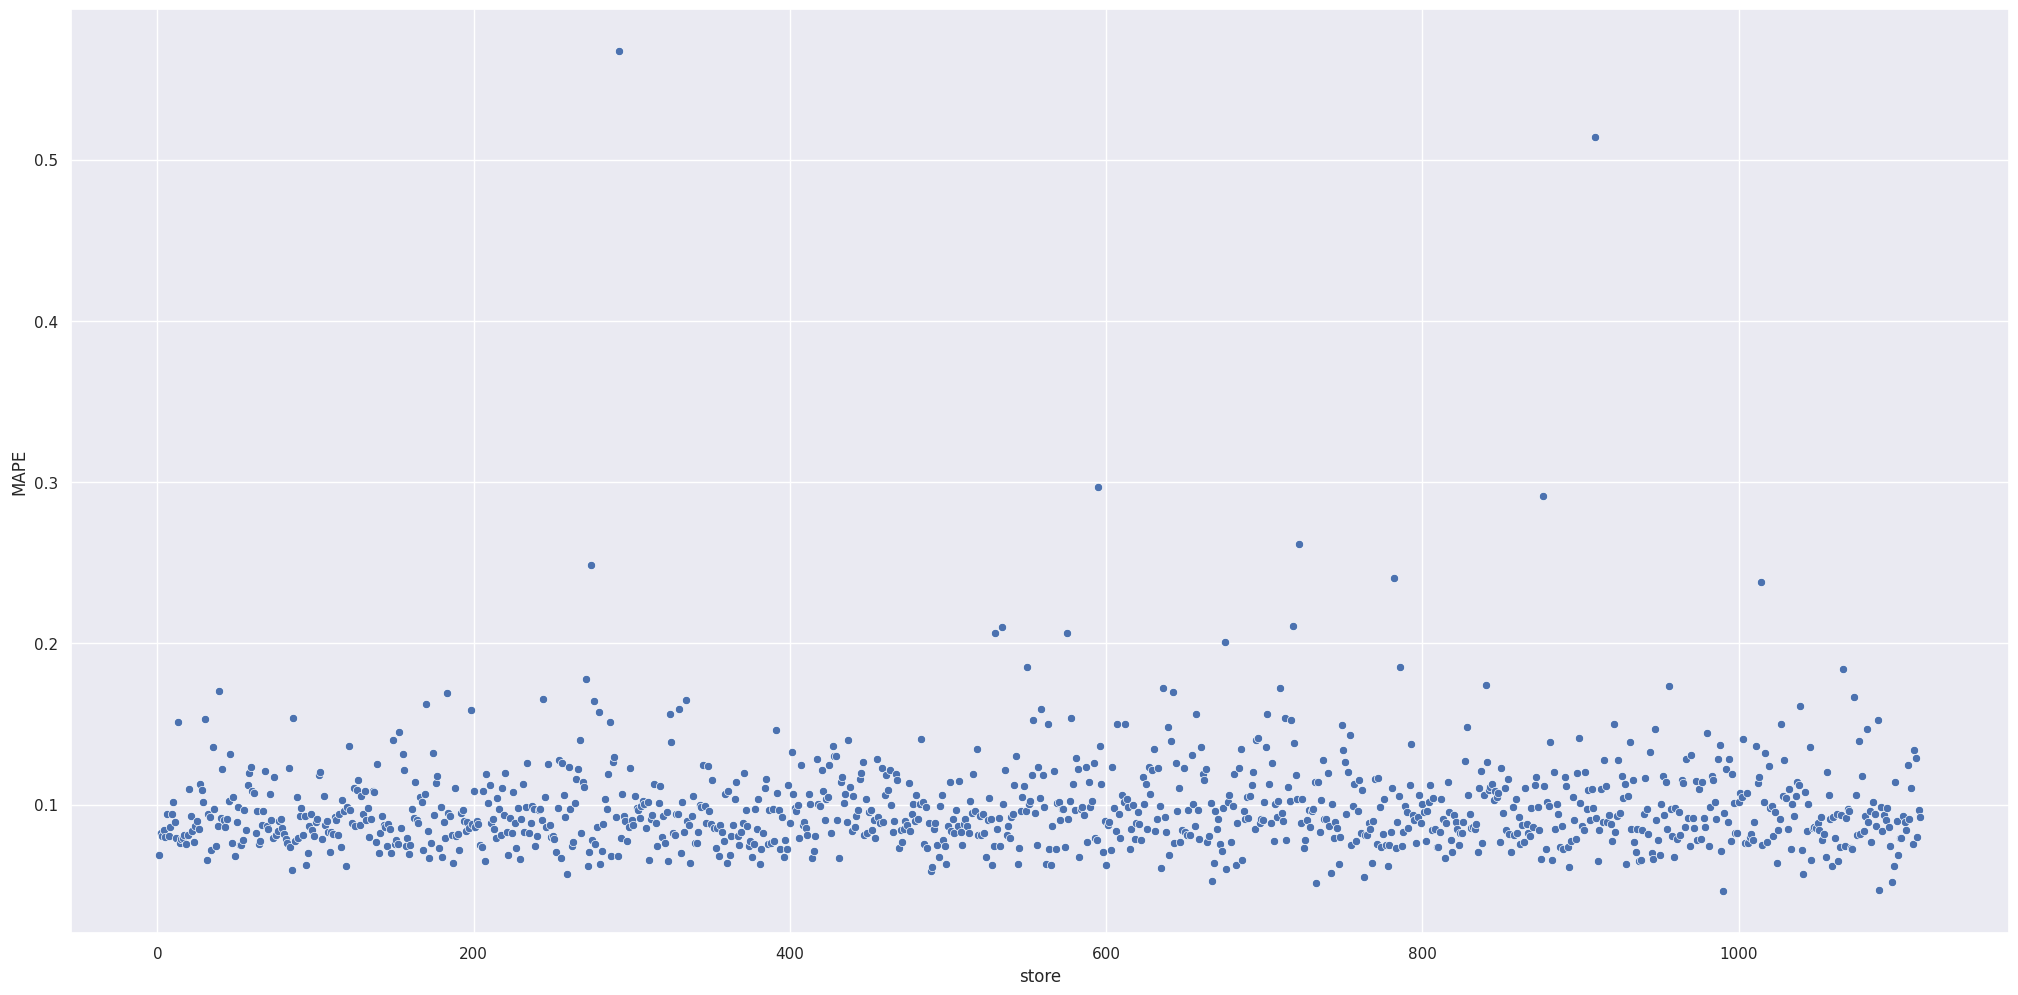

In [82]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [83]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenarios', 0: 'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

,scenarios,values
0,predictions,"R$286,922,304.00"
1,worst_scenario,"R$286,176,354.06"
2,best_scenario,"R$287,668,215.22"


## 9.3. Machine Learning Performance

In [84]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_3038/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_3038/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/tmp/ipykernel_3038/2975729870.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error']);


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

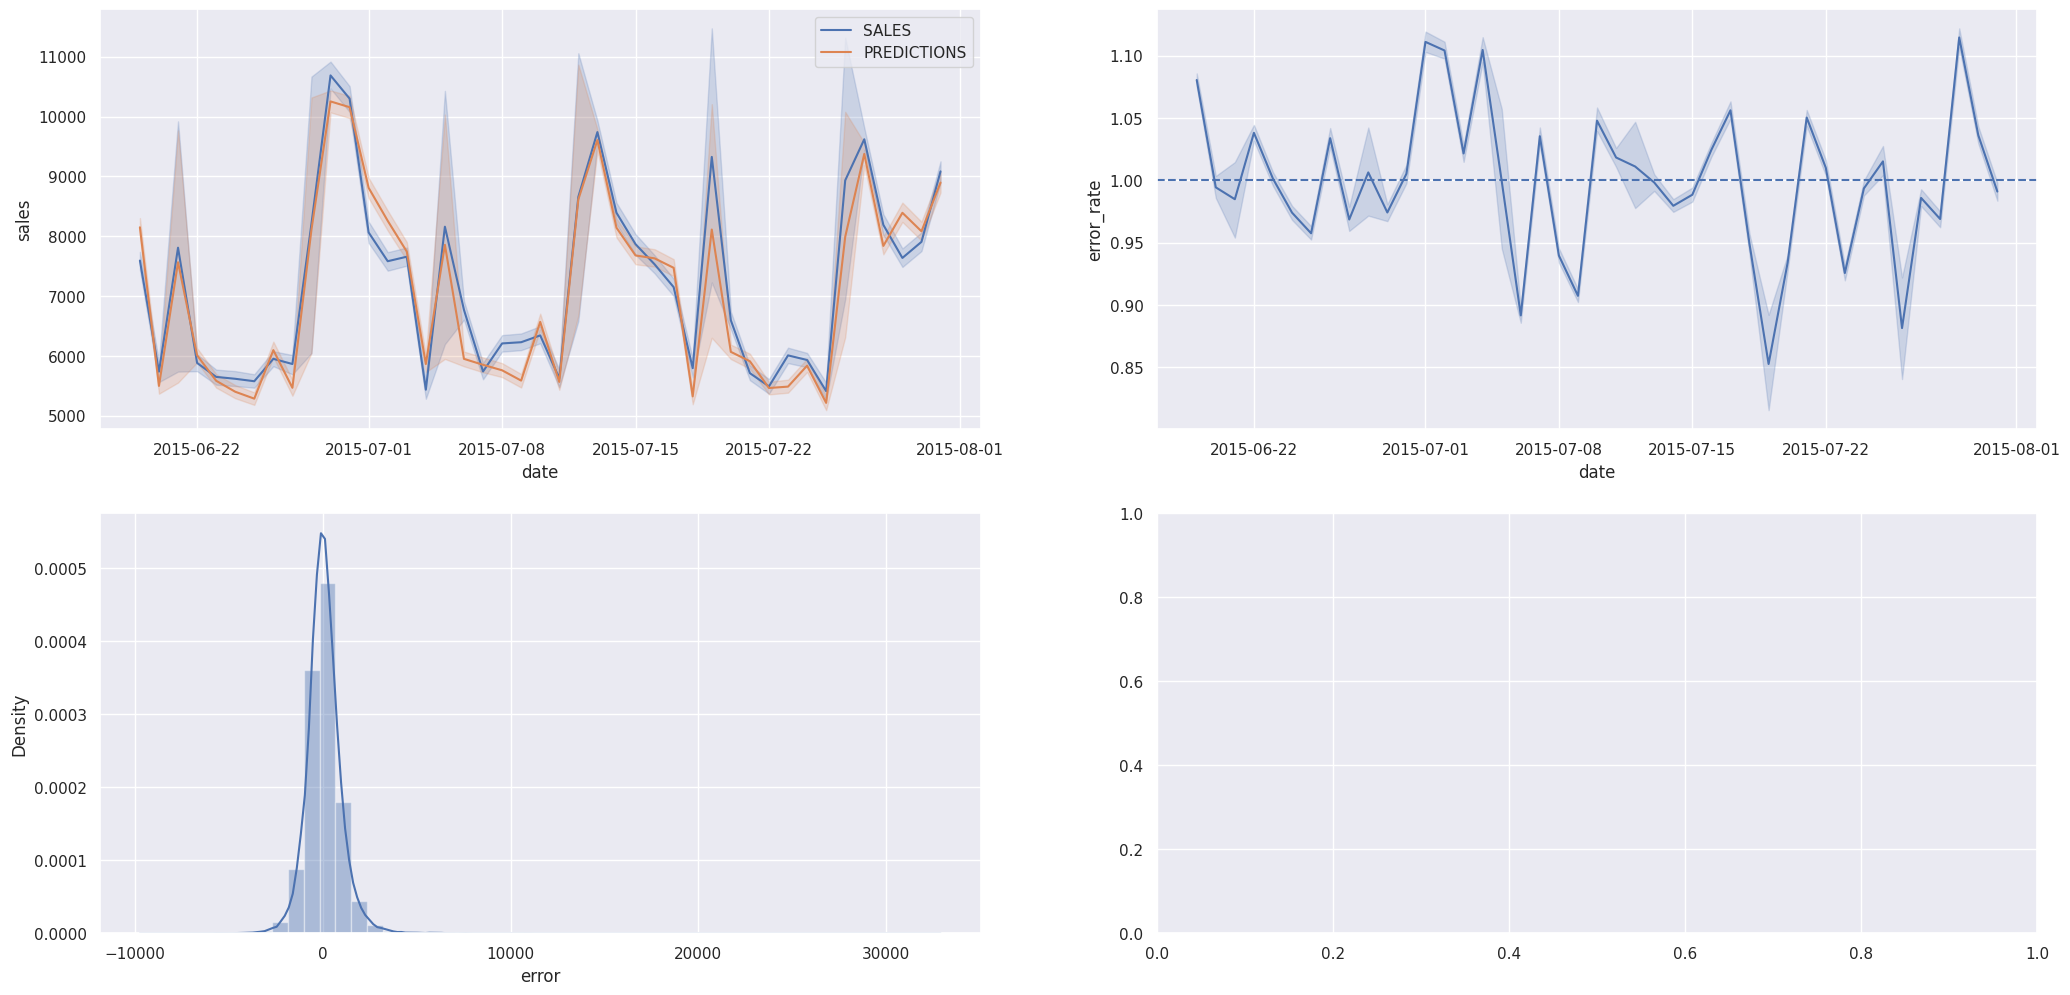

In [85]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);